## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


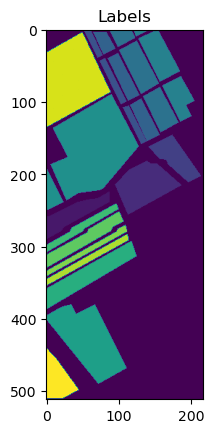

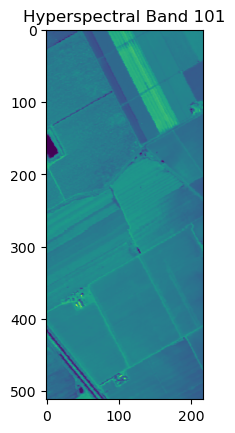

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53889 samples
	shape (53889, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(160, 5, 5, 204)
(80, 5, 5, 204)
(53889, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1642, PSNR: 6.5396


	 Training Batch [200/677], Loss: 0.0919, PSNR: 9.4496


	 Training Batch [400/677], Loss: 0.0479, PSNR: 12.3221


	 Training Batch [600/677], Loss: 0.0258, PSNR: 14.9907


Epoch [1/50] Training Loss: 0.0691, PSNR: 11.4847
	[Val]   Batch [1/170] Loss: 0.0219, PSNR: 15.6926
	[Val]   Batch [10/170] Loss: 0.0215, PSNR: 15.8616
	[Val]   Batch [20/170] Loss: 0.0216, PSNR: 15.7672
	[Val]   Batch [30/170] Loss: 0.0223, PSNR: 15.5578
	[Val]   Batch [40/170] Loss: 0.0224, PSNR: 15.6296


	[Val]   Batch [50/170] Loss: 0.0212, PSNR: 15.8520
	[Val]   Batch [60/170] Loss: 0.0222, PSNR: 15.7148
	[Val]   Batch [70/170] Loss: 0.0218, PSNR: 15.7933
	[Val]   Batch [80/170] Loss: 0.0221, PSNR: 15.6159
	[Val]   Batch [90/170] Loss: 0.0214, PSNR: 15.8552


	[Val]   Batch [100/170] Loss: 0.0216, PSNR: 15.7645
	[Val]   Batch [110/170] Loss: 0.0216, PSNR: 15.7663
	[Val]   Batch [120/170] Loss: 0.0203, PSNR: 14.0813
	[Val]   Batch [130/170] Loss: 0.0215, PSNR: 15.8464
	[Val]   Batch [140/170] Loss: 0.0210, PSNR: 15.9248


	[Val]   Batch [150/170] Loss: 0.0225, PSNR: 15.6592
	[Val]   Batch [160/170] Loss: 0.0221, PSNR: 15.6948
	[Val]   Batch [170/170] Loss: 0.0230, PSNR: 14.9797
Epoch [1/50] Validation Loss: 0.0218, PSNR: 15.6844

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0199, PSNR: 15.9184


	 Training Batch [200/677], Loss: 0.0153, PSNR: 17.3402


	 Training Batch [400/677], Loss: 0.0120, PSNR: 18.2764


	 Training Batch [600/677], Loss: 0.0092, PSNR: 19.4853


Epoch [2/50] Training Loss: 0.0133, PSNR: 17.9960
	[Val]   Batch [1/170] Loss: 0.0090, PSNR: 19.5593
	[Val]   Batch [10/170] Loss: 0.0085, PSNR: 19.8985
	[Val]   Batch [20/170] Loss: 0.0086, PSNR: 19.7708
	[Val]   Batch [30/170] Loss: 0.0093, PSNR: 19.3776
	[Val]   Batch [40/170] Loss: 0.0095, PSNR: 19.3613


	[Val]   Batch [50/170] Loss: 0.0083, PSNR: 19.9390
	[Val]   Batch [60/170] Loss: 0.0093, PSNR: 19.5102
	[Val]   Batch [70/170] Loss: 0.0090, PSNR: 19.6124
	[Val]   Batch [80/170] Loss: 0.0091, PSNR: 19.4586


	[Val]   Batch [90/170] Loss: 0.0087, PSNR: 19.7664
	[Val]   Batch [100/170] Loss: 0.0088, PSNR: 19.6773
	[Val]   Batch [110/170] Loss: 0.0086, PSNR: 19.7407
	[Val]   Batch [120/170] Loss: 0.0075, PSNR: 18.4053
	[Val]   Batch [130/170] Loss: 0.0087, PSNR: 19.7625


	[Val]   Batch [140/170] Loss: 0.0081, PSNR: 20.0570
	[Val]   Batch [150/170] Loss: 0.0095, PSNR: 19.3955
	[Val]   Batch [160/170] Loss: 0.0092, PSNR: 19.5016
	[Val]   Batch [170/170] Loss: 0.0096, PSNR: 18.7926
Epoch [2/50] Validation Loss: 0.0089, PSNR: 19.6053

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0075, PSNR: 20.3603


	 Training Batch [200/677], Loss: 0.0071, PSNR: 20.6051


	 Training Batch [400/677], Loss: 0.0067, PSNR: 20.9321


	 Training Batch [600/677], Loss: 0.0062, PSNR: 21.1381


Epoch [3/50] Training Loss: 0.0068, PSNR: 20.7856
	[Val]   Batch [1/170] Loss: 0.0053, PSNR: 21.8798
	[Val]   Batch [10/170] Loss: 0.0049, PSNR: 22.2540
	[Val]   Batch [20/170] Loss: 0.0050, PSNR: 22.1190
	[Val]   Batch [30/170] Loss: 0.0055, PSNR: 21.6743
	[Val]   Batch [40/170] Loss: 0.0056, PSNR: 21.6226


	[Val]   Batch [50/170] Loss: 0.0048, PSNR: 22.2868
	[Val]   Batch [60/170] Loss: 0.0055, PSNR: 21.7960
	[Val]   Batch [70/170] Loss: 0.0053, PSNR: 21.9053
	[Val]   Batch [80/170] Loss: 0.0054, PSNR: 21.7799
	[Val]   Batch [90/170] Loss: 0.0051, PSNR: 22.0695


	[Val]   Batch [100/170] Loss: 0.0052, PSNR: 21.9692
	[Val]   Batch [110/170] Loss: 0.0051, PSNR: 22.0622
	[Val]   Batch [120/170] Loss: 0.0043, PSNR: 20.8263
	[Val]   Batch [130/170] Loss: 0.0051, PSNR: 22.0722
	[Val]   Batch [140/170] Loss: 0.0047, PSNR: 22.4554


	[Val]   Batch [150/170] Loss: 0.0056, PSNR: 21.6729
	[Val]   Batch [160/170] Loss: 0.0054, PSNR: 21.7938
	[Val]   Batch [170/170] Loss: 0.0055, PSNR: 21.1572
Epoch [3/50] Validation Loss: 0.0052, PSNR: 21.9348

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0056, PSNR: 21.7008


	 Training Batch [200/677], Loss: 0.0043, PSNR: 22.7406


	 Training Batch [400/677], Loss: 0.0036, PSNR: 23.6543


	 Training Batch [600/677], Loss: 0.0029, PSNR: 24.5211


Epoch [4/50] Training Loss: 0.0039, PSNR: 23.1918
	[Val]   Batch [1/170] Loss: 0.0029, PSNR: 24.4372
	[Val]   Batch [10/170] Loss: 0.0028, PSNR: 24.6966
	[Val]   Batch [20/170] Loss: 0.0028, PSNR: 24.5608
	[Val]   Batch [30/170] Loss: 0.0031, PSNR: 24.1448
	[Val]   Batch [40/170] Loss: 0.0031, PSNR: 24.2880


	[Val]   Batch [50/170] Loss: 0.0028, PSNR: 24.6061
	[Val]   Batch [60/170] Loss: 0.0030, PSNR: 24.3400
	[Val]   Batch [70/170] Loss: 0.0029, PSNR: 24.5332
	[Val]   Batch [80/170] Loss: 0.0029, PSNR: 24.3727
	[Val]   Batch [90/170] Loss: 0.0029, PSNR: 24.5618


	[Val]   Batch [100/170] Loss: 0.0030, PSNR: 24.3330
	[Val]   Batch [110/170] Loss: 0.0028, PSNR: 24.5655
	[Val]   Batch [120/170] Loss: 0.0027, PSNR: 22.9176
	[Val]   Batch [130/170] Loss: 0.0030, PSNR: 24.4149


	[Val]   Batch [140/170] Loss: 0.0027, PSNR: 24.8739
	[Val]   Batch [150/170] Loss: 0.0031, PSNR: 24.2880
	[Val]   Batch [160/170] Loss: 0.0030, PSNR: 24.3817
	[Val]   Batch [170/170] Loss: 0.0031, PSNR: 23.6894
Epoch [4/50] Validation Loss: 0.0029, PSNR: 24.4173

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0029, PSNR: 24.0488


	 Training Batch [200/677], Loss: 0.0026, PSNR: 25.0128


	 Training Batch [400/677], Loss: 0.0023, PSNR: 25.2532


	 Training Batch [600/677], Loss: 0.0028, PSNR: 24.6885


Epoch [5/50] Training Loss: 0.0025, PSNR: 25.1482
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.2875
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.5593
	[Val]   Batch [20/170] Loss: 0.0019, PSNR: 26.3453
	[Val]   Batch [30/170] Loss: 0.0021, PSNR: 25.8849
	[Val]   Batch [40/170] Loss: 0.0020, PSNR: 26.2299


	[Val]   Batch [50/170] Loss: 0.0019, PSNR: 26.3692
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.1514
	[Val]   Batch [70/170] Loss: 0.0019, PSNR: 26.4460
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.2359
	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.4018


	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.0489
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.5297
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.5781
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.1187
	[Val]   Batch [140/170] Loss: 0.0018, PSNR: 26.7076


	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.1104
	[Val]   Batch [160/170] Loss: 0.0020, PSNR: 26.2323
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.5229
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.2301

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0019, PSNR: 26.3041


	 Training Batch [200/677], Loss: 0.0019, PSNR: 26.2885


	 Training Batch [400/677], Loss: 0.0018, PSNR: 26.5344


	 Training Batch [600/677], Loss: 0.0018, PSNR: 26.6925


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.4488
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.5056
	[Val]   Batch [10/170] Loss: 0.0014, PSNR: 27.7698
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.5114
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 27.0255
	[Val]   Batch [40/170] Loss: 0.0015, PSNR: 27.4980


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.5153
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.3339
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.7111
	[Val]   Batch [80/170] Loss: 0.0015, PSNR: 27.4439
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.6240


	[Val]   Batch [100/170] Loss: 0.0016, PSNR: 27.1740
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 27.8317
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.6942
	[Val]   Batch [130/170] Loss: 0.0016, PSNR: 27.2432
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 27.9243


	[Val]   Batch [150/170] Loss: 0.0016, PSNR: 27.2791
	[Val]   Batch [160/170] Loss: 0.0015, PSNR: 27.4419
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.7253
Epoch [6/50] Validation Loss: 0.0015, PSNR: 27.4184

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0017, PSNR: 26.8936


	 Training Batch [200/677], Loss: 0.0018, PSNR: 26.5963


	 Training Batch [400/677], Loss: 0.0015, PSNR: 27.3892


	 Training Batch [600/677], Loss: 0.0014, PSNR: 27.7989


Epoch [7/50] Training Loss: 0.0015, PSNR: 27.4147
	[Val]   Batch [1/170] Loss: 0.0012, PSNR: 28.4112
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.6692
	[Val]   Batch [20/170] Loss: 0.0012, PSNR: 28.3642
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 27.8431
	[Val]   Batch [40/170] Loss: 0.0012, PSNR: 28.4339


	[Val]   Batch [50/170] Loss: 0.0012, PSNR: 28.3789
	[Val]   Batch [60/170] Loss: 0.0013, PSNR: 28.1877
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.6708
	[Val]   Batch [80/170] Loss: 0.0012, PSNR: 28.3229
	[Val]   Batch [90/170] Loss: 0.0012, PSNR: 28.5590


	[Val]   Batch [100/170] Loss: 0.0013, PSNR: 28.0171
	[Val]   Batch [110/170] Loss: 0.0011, PSNR: 28.8006
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.5824
	[Val]   Batch [130/170] Loss: 0.0013, PSNR: 28.0727
	[Val]   Batch [140/170] Loss: 0.0011, PSNR: 28.8571


	[Val]   Batch [150/170] Loss: 0.0013, PSNR: 28.1018
	[Val]   Batch [160/170] Loss: 0.0012, PSNR: 28.3403
	[Val]   Batch [170/170] Loss: 0.0013, PSNR: 27.5775
Epoch [7/50] Validation Loss: 0.0012, PSNR: 28.2900

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.6246


	 Training Batch [200/677], Loss: 0.0013, PSNR: 27.9286


	 Training Batch [400/677], Loss: 0.0013, PSNR: 28.1394


	 Training Batch [600/677], Loss: 0.0012, PSNR: 28.3891


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.2196
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.4292
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.6779
	[Val]   Batch [20/170] Loss: 0.0010, PSNR: 29.3249
	[Val]   Batch [30/170] Loss: 0.0011, PSNR: 28.8167
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.5065


	[Val]   Batch [50/170] Loss: 0.0010, PSNR: 29.2511
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.1983
	[Val]   Batch [70/170] Loss: 0.0009, PSNR: 29.7322
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.3786
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.5688


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 28.9812
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 29.8677
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.4087
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.0438
	[Val]   Batch [140/170] Loss: 0.0009, PSNR: 29.8309


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.1311
	[Val]   Batch [160/170] Loss: 0.0010, PSNR: 29.3554
	[Val]   Batch [170/170] Loss: 0.0010, PSNR: 28.7081
Epoch [8/50] Validation Loss: 0.0010, PSNR: 29.2889

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.4443


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.9104


	 Training Batch [400/677], Loss: 0.0010, PSNR: 28.9920


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.5256


Epoch [9/50] Training Loss: 0.0010, PSNR: 28.9110
	[Val]   Batch [1/170] Loss: 0.0008, PSNR: 30.1255
	[Val]   Batch [10/170] Loss: 0.0008, PSNR: 30.4085
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.0153
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.4853
	[Val]   Batch [40/170] Loss: 0.0008, PSNR: 30.1872
	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 29.9731


	[Val]   Batch [60/170] Loss: 0.0009, PSNR: 29.8653
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 30.4101
	[Val]   Batch [80/170] Loss: 0.0008, PSNR: 30.0837
	[Val]   Batch [90/170] Loss: 0.0008, PSNR: 30.3347
	[Val]   Batch [100/170] Loss: 0.0009, PSNR: 29.7066


	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.6086
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.1631
	[Val]   Batch [130/170] Loss: 0.0009, PSNR: 29.7350
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.6030
	[Val]   Batch [150/170] Loss: 0.0009, PSNR: 29.7718


	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.0025
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 29.2995
Epoch [9/50] Validation Loss: 0.0008, PSNR: 29.9723

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.8961


	 Training Batch [200/677], Loss: 0.0010, PSNR: 29.2854


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.1803


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.5359


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.5784
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.2078
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.5040
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.0816
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.5717
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.2814


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.9372
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.9611
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.4800
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.2298
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.4455


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.8053
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 31.7581
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.0847
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.8679
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.6619


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.8920
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.0479
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.6301
Epoch [10/50] Validation Loss: 0.0006, PSNR: 31.0662

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.6150


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.5501


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.7743


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.5623


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.1606
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.8610
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.1676
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.6806
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.2820
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.9193


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.5636
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.6484
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.0878
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.9114
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.1607


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.5390
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.3546
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.7588
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.5895
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.3341


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.5997
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.6628
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.3816
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.7273

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.1172


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.8918


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.7495


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.4571


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.6712
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.4712
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.7897
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.2893
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.9582
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.5342


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.1399
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.3059
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.6404
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.5576
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.8367


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.2360
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.9824
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.3977
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.2807


	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.9345
	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.2772
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.2236
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.0870
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.3527

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.1503


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.9187


	 Training Batch [400/677], Loss: 0.0006, PSNR: 30.5016


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.7943


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.1501
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.1365
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.5002
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.9513
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.6475
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.2069


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.7420
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.0109
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.3022
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.2796
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.5737


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.9977
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.6897
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.0587
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.0338
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.6217


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.0018
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.8698
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.9631
Epoch [13/50] Validation Loss: 0.0004, PSNR: 33.0464

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.5738


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.8094


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.8553


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.5569


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.5596
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.6520
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.0082
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.4391
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.2357
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.7646


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.1876
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.6066
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.7801
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.8594


	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.1311
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.5593
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.2082
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.4953
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.6430


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.1063
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.6172
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3588
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.6064
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.5814

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.1388


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.4869


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.6399


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.9757


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.8532
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.9890
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.3795
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.8067
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.6169
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.1068


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.4665
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.9929
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.0797
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.2475
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.5153


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.9797
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.5669
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.8386
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.0644


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.4649
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.0146
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.6778
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.1137
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.9489

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 31.7548


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.0037


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.1481


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.3337


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.1572
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.2824
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.5981
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.9980
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.8926
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.3613
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.8274


	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.2383
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.3631
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.4444
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.8394


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.2426
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.8156
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.2145
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.3124
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.7293


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.2111
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.9001
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.1817
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.1796

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.8167


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5958


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.5943


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.9815


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.4383
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.9058
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.2808
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.6217
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.5524
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.0062


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.3638
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.9330
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.9562
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.1592
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.5288


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9233
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.5124
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.7533
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0218
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.3982


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.9404
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.5108
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.0216
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.8344
Early stopping triggered at epoch 17. No improvement for 3 epochs.


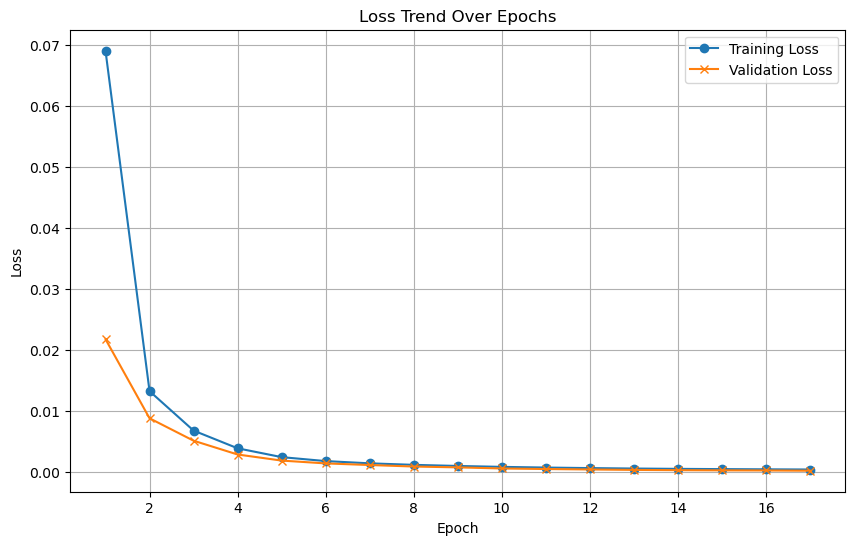

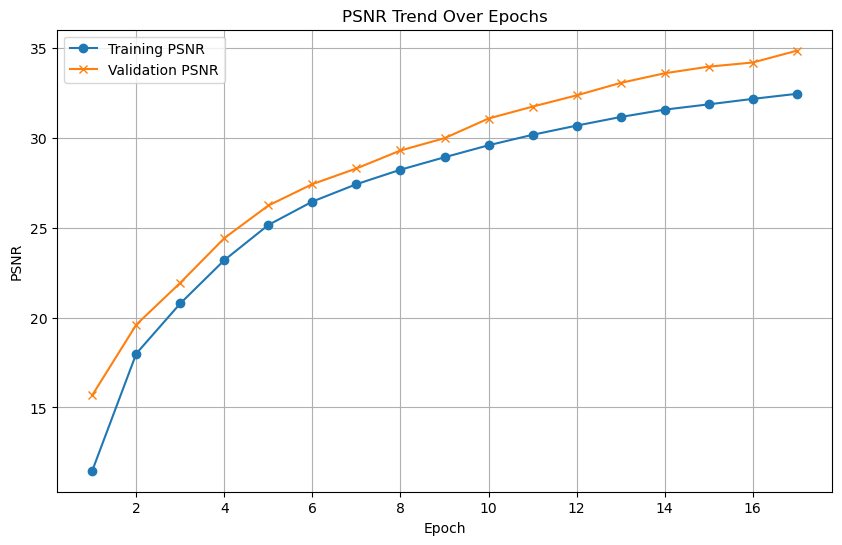

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7897
    Validation Batch [1/1], Loss: 2.7750
Validation Loss: 2.7750, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7750. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7424
    Validation Batch [1/1], Loss: 2.7750
Validation Loss: 2.7750, Validation Accuracy: 6.25%
Validation loss improved from 2.7750 to 2.7750. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7250
    Validation Batch [1/1], Loss: 2.7750
Validation Loss: 2.7750, Validation Accuracy: 6.25%
Validation loss improved from 2.7750 to 2.7750. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6931
    Validation Batch [1/1], Loss: 2.7749
Validation Loss: 2.7749, Validation Accuracy: 6.25%
Validation loss improved from 2.7750 to 2.7749. Saving model...

LOG: Epoch [5/1000] - 

Epoch [18/1000] completed, Average Training Loss: 2.5217
    Validation Batch [1/1], Loss: 2.7745
Validation Loss: 2.7745, Validation Accuracy: 6.25%
Validation loss improved from 2.7745 to 2.7745. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.4979
    Validation Batch [1/1], Loss: 2.7745
Validation Loss: 2.7745, Validation Accuracy: 6.25%
Validation loss improved from 2.7745 to 2.7745. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4865
    Validation Batch [1/1], Loss: 2.7743
Validation Loss: 2.7743, Validation Accuracy: 6.25%
Validation loss improved from 2.7745 to 2.7743. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4885
    Validation Batch [1/1], Loss: 2.7742
Validation Loss: 2.7742, Validation Accuracy: 6.25%
Validation loss improved from 2.7743 to 2.7742. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/10

Epoch [46/1000] completed, Average Training Loss: 2.2735
    Validation Batch [1/1], Loss: 2.6362
Validation Loss: 2.6362, Validation Accuracy: 32.50%
Validation loss improved from 2.6508 to 2.6362. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.2387
    Validation Batch [1/1], Loss: 2.6199
Validation Loss: 2.6199, Validation Accuracy: 35.00%
Validation loss improved from 2.6362 to 2.6199. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.2457
    Validation Batch [1/1], Loss: 2.6015
Validation Loss: 2.6015, Validation Accuracy: 36.25%
Validation loss improved from 2.6199 to 2.6015. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.2390
    Validation Batch [1/1], Loss: 2.5824
Validation Loss: 2.5824, Validation Accuracy: 37.50%
Validation loss improved from 2.6015 to 2.5824. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 2.1260
Validation Loss: 2.1260, Validation Accuracy: 73.75%
Validation loss improved from 2.1412 to 2.1260. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 2.0024
    Validation Batch [1/1], Loss: 2.1140
Validation Loss: 2.1140, Validation Accuracy: 71.25%
Validation loss improved from 2.1260 to 2.1140. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 2.0171
    Validation Batch [1/1], Loss: 2.1076
Validation Loss: 2.1076, Validation Accuracy: 72.50%
Validation loss improved from 2.1140 to 2.1076. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.9552
    Validation Batch [1/1], Loss: 2.1012
Validation Loss: 2.1012, Validation Accuracy: 76.25%
Validation loss improved from 2.1076 to 2.1012. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.9492
    Vali

Epoch [97/1000] completed, Average Training Loss: 1.7782
    Validation Batch [1/1], Loss: 1.8503
Validation Loss: 1.8503, Validation Accuracy: 77.50%
Validation loss improved from 1.8545 to 1.8503. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.7583
    Validation Batch [1/1], Loss: 1.8438
Validation Loss: 1.8438, Validation Accuracy: 80.00%
Validation loss improved from 1.8503 to 1.8438. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.7549
    Validation Batch [1/1], Loss: 1.8440
Validation Loss: 1.8440, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.7813
    Validation Batch [1/1], Loss: 1.8452
Validation Loss: 1.8452, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average

    Validation Batch [1/1], Loss: 1.6130
Validation Loss: 1.6130, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.4939
    Validation Batch [1/1], Loss: 1.6118
Validation Loss: 1.6118, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.4695
    Validation Batch [1/1], Loss: 1.6032
Validation Loss: 1.6032, Validation Accuracy: 80.00%
Validation loss improved from 1.6106 to 1.6032. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.4484
    Validation Batch [1/1], Loss: 1.5625
Validation Loss: 1.5625, Validation Accuracy: 81.25%
Validation loss improved from 1.6032 to 1.5625. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.4595
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 1.3630
Validation Loss: 1.3630, Validation Accuracy: 83.75%
Validation loss improved from 1.3824 to 1.3630. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.2907
    Validation Batch [1/1], Loss: 1.3518
Validation Loss: 1.3518, Validation Accuracy: 85.00%
Validation loss improved from 1.3630 to 1.3518. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.2468
    Validation Batch [1/1], Loss: 1.3571
Validation Loss: 1.3571, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.2614
    Validation Batch [1/1], Loss: 1.3606
Validation Loss: 1.3606, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.2273
    Validation Batch [1/1], Lo

Epoch [177/1000] completed, Average Training Loss: 1.0623
    Validation Batch [1/1], Loss: 1.1684
Validation Loss: 1.1684, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.9863
    Validation Batch [1/1], Loss: 1.1723
Validation Loss: 1.1723, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.0144
    Validation Batch [1/1], Loss: 1.1420
Validation Loss: 1.1420, Validation Accuracy: 88.75%
Validation loss improved from 1.1466 to 1.1420. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.0145
    Validation Batch [1/1], Loss: 1.1267
Validation Loss: 1.1267, Validation Accuracy: 87.50%
Validation loss improved from 1.1420 to 1.1267. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Av

Epoch [205/1000] completed, Average Training Loss: 0.8364
    Validation Batch [1/1], Loss: 0.9605
Validation Loss: 0.9605, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.8277
    Validation Batch [1/1], Loss: 0.9588
Validation Loss: 0.9588, Validation Accuracy: 90.00%
Validation loss improved from 0.9597 to 0.9588. Saving model...

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.8539
    Validation Batch [1/1], Loss: 0.9436
Validation Loss: 0.9436, Validation Accuracy: 88.75%
Validation loss improved from 0.9588 to 0.9436. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.7513
    Validation Batch [1/1], Loss: 0.9417
Validation Loss: 0.9417, Validation Accuracy: 87.50%
Validation loss improved from 0.9436 to 0.9417. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000

Epoch [231/1000] completed, Average Training Loss: 0.6582
    Validation Batch [1/1], Loss: 0.8020
Validation Loss: 0.8020, Validation Accuracy: 91.25%
Validation loss improved from 0.8134 to 0.8020. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.6761
    Validation Batch [1/1], Loss: 0.7944
Validation Loss: 0.7944, Validation Accuracy: 91.25%
Validation loss improved from 0.8020 to 0.7944. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.6770
    Validation Batch [1/1], Loss: 0.7988
Validation Loss: 0.7988, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.6551
    Validation Batch [1/1], Loss: 0.7848
Validation Loss: 0.7848, Validation Accuracy: 92.50%
Validation loss improved from 0.7944 to 0.7848. Saving model...

LOG: Epoch [235/1000] - Training
Epoch [235/1000

Epoch [257/1000] completed, Average Training Loss: 0.5264
    Validation Batch [1/1], Loss: 0.6716
Validation Loss: 0.6716, Validation Accuracy: 92.50%
Validation loss improved from 0.6823 to 0.6716. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5192
    Validation Batch [1/1], Loss: 0.6629
Validation Loss: 0.6629, Validation Accuracy: 92.50%
Validation loss improved from 0.6716 to 0.6629. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.4990
    Validation Batch [1/1], Loss: 0.6749
Validation Loss: 0.6749, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.5039
    Validation Batch [1/1], Loss: 0.6771
Validation Loss: 0.6771, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Av

    Validation Batch [1/1], Loss: 0.5724
Validation Loss: 0.5724, Validation Accuracy: 92.50%
Validation loss improved from 0.5795 to 0.5724. Saving model...

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.4303
    Validation Batch [1/1], Loss: 0.5750
Validation Loss: 0.5750, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.3772
    Validation Batch [1/1], Loss: 0.6219
Validation Loss: 0.6219, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.3995
    Validation Batch [1/1], Loss: 0.5815
Validation Loss: 0.5815, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.3894
    Validation Batch [1/1], Loss: 0.5565
Vali

Epoch [313/1000] completed, Average Training Loss: 0.2989
    Validation Batch [1/1], Loss: 0.4903
Validation Loss: 0.4903, Validation Accuracy: 92.50%
Validation loss improved from 0.4973 to 0.4903. Saving model...

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.3285
    Validation Batch [1/1], Loss: 0.4834
Validation Loss: 0.4834, Validation Accuracy: 92.50%
Validation loss improved from 0.4903 to 0.4834. Saving model...

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3494
    Validation Batch [1/1], Loss: 0.4909
Validation Loss: 0.4909, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.3431
    Validation Batch [1/1], Loss: 0.4930
Validation Loss: 0.4930, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Av

    Validation Batch [1/1], Loss: 0.4317
Validation Loss: 0.4317, Validation Accuracy: 95.00%
Validation loss improved from 0.4354 to 0.4317. Saving model...

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2550
    Validation Batch [1/1], Loss: 0.4490
Validation Loss: 0.4490, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2917
    Validation Batch [1/1], Loss: 0.4689
Validation Loss: 0.4689, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2691
    Validation Batch [1/1], Loss: 0.4526
Validation Loss: 0.4526, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.2653
    Validation Batch [1/1], Loss: 0.4560
Vali

Epoch [363/1000] completed, Average Training Loss: 0.2465
    Validation Batch [1/1], Loss: 0.4055
Validation Loss: 0.4055, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.2111
    Validation Batch [1/1], Loss: 0.4110
Validation Loss: 0.4110, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2465
    Validation Batch [1/1], Loss: 0.4307
Validation Loss: 0.4307, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2364
    Validation Batch [1/1], Loss: 0.4284
Validation Loss: 0.4284, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2407
  

Epoch [392/1000] completed, Average Training Loss: 0.1786
    Validation Batch [1/1], Loss: 0.3845
Validation Loss: 0.3845, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.1774
    Validation Batch [1/1], Loss: 0.3753
Validation Loss: 0.3753, Validation Accuracy: 92.50%
Validation loss improved from 0.3759 to 0.3753. Saving model...

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.1701
    Validation Batch [1/1], Loss: 0.3889
Validation Loss: 0.3889, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.1941
    Validation Batch [1/1], Loss: 0.4007
Validation Loss: 0.4007, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training 

Epoch [419/1000] completed, Average Training Loss: 0.1419
    Validation Batch [1/1], Loss: 0.3837
Validation Loss: 0.3837, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1403
    Validation Batch [1/1], Loss: 0.3864
Validation Loss: 0.3864, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.1630
    Validation Batch [1/1], Loss: 0.3679
Validation Loss: 0.3679, Validation Accuracy: 95.00%
Validation loss improved from 0.3752 to 0.3679. Saving model...

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1651
    Validation Batch [1/1], Loss: 0.3752
Validation Loss: 0.3752, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training 

Epoch [446/1000] completed, Average Training Loss: 0.1712
    Validation Batch [1/1], Loss: 0.3462
Validation Loss: 0.3462, Validation Accuracy: 93.75%
Validation loss improved from 0.3497 to 0.3462. Saving model...

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1353
    Validation Batch [1/1], Loss: 0.3470
Validation Loss: 0.3470, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1379
    Validation Batch [1/1], Loss: 0.3483
Validation Loss: 0.3483, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.1362
    Validation Batch [1/1], Loss: 0.3463
Validation Loss: 0.3463, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training 

Epoch [473/1000] completed, Average Training Loss: 0.0978
    Validation Batch [1/1], Loss: 0.3456
Validation Loss: 0.3456, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.1158
    Validation Batch [1/1], Loss: 0.3429
Validation Loss: 0.3429, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.0801
    Validation Batch [1/1], Loss: 0.3460
Validation Loss: 0.3460, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.1172
    Validation Batch [1/1], Loss: 0.3486
Validation Loss: 0.3486, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1084
  

    Validation Batch [1/1], Loss: 0.3444
Validation Loss: 0.3444, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0881
    Validation Batch [1/1], Loss: 0.3420
Validation Loss: 0.3420, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.1009
    Validation Batch [1/1], Loss: 0.3400
Validation Loss: 0.3400, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0824
    Validation Batch [1/1], Loss: 0.3434
Validation Loss: 0.3434, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0968
    Validation Batch [1/1], Loss: 0.3380
Validation Loss

    Validation Batch [1/1], Loss: 0.3257
Validation Loss: 0.3257, Validation Accuracy: 93.75%
Validation loss improved from 0.3315 to 0.3257. Saving model...

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0830
    Validation Batch [1/1], Loss: 0.3271
Validation Loss: 0.3271, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0920
    Validation Batch [1/1], Loss: 0.3336
Validation Loss: 0.3336, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0910
    Validation Batch [1/1], Loss: 0.3459
Validation Loss: 0.3459, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0904
    Validation Batch [1/1], Loss: 0.3575
Vali

Epoch [552/1000] completed, Average Training Loss: 0.0726
    Validation Batch [1/1], Loss: 0.3428
Validation Loss: 0.3428, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0822
    Validation Batch [1/1], Loss: 0.3422
Validation Loss: 0.3422, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0740
    Validation Batch [1/1], Loss: 0.3390
Validation Loss: 0.3390, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0740
    Validation Batch [1/1], Loss: 0.3394
Validation Loss: 0.3394, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.086

    Validation Batch [1/1], Loss: 0.3133
Validation Loss: 0.3133, Validation Accuracy: 95.00%
Validation loss improved from 0.3137 to 0.3133. Saving model...

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.0691
    Validation Batch [1/1], Loss: 0.3296
Validation Loss: 0.3296, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0745
    Validation Batch [1/1], Loss: 0.3288
Validation Loss: 0.3288, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0682
    Validation Batch [1/1], Loss: 0.3324
Validation Loss: 0.3324, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0733
    Validation Batch [1/1], Loss: 0.3651
Vali

    Validation Batch [1/1], Loss: 0.3704
Validation Loss: 0.3704, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.0794
    Validation Batch [1/1], Loss: 0.3584
Validation Loss: 0.3584, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.0660
    Validation Batch [1/1], Loss: 0.3458
Validation Loss: 0.3458, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0684
    Validation Batch [1/1], Loss: 0.3635
Validation Loss: 0.3635, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0616
    Validation Batch [1/1], Loss: 0.3807
Validation Loss

    Validation Batch [1/1], Loss: 0.3502
Validation Loss: 0.3502, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Training Loss: 0.0539
    Validation Batch [1/1], Loss: 0.3473
Validation Loss: 0.3473, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [636/1000] - Training
Epoch [636/1000] completed, Average Training Loss: 0.0560
    Validation Batch [1/1], Loss: 0.3375
Validation Loss: 0.3375, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.3346
Validation Loss: 0.3346, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0539
    Validation Batch [1/1], Loss: 0.3338
Validation Loss

Epoch [662/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.4012
Validation Loss: 0.4012, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [663/1000] - Training
Epoch [663/1000] completed, Average Training Loss: 0.0417
    Validation Batch [1/1], Loss: 0.3300
Validation Loss: 0.3300, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.0508
    Validation Batch [1/1], Loss: 0.3141
Validation Loss: 0.3141, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [665/1000] - Training
Epoch [665/1000] completed, Average Training Loss: 0.0483
    Validation Batch [1/1], Loss: 0.3248
Validation Loss: 0.3248, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [666/1000] - Training
Epoch [666/1000] completed, Average Training Loss: 0.052

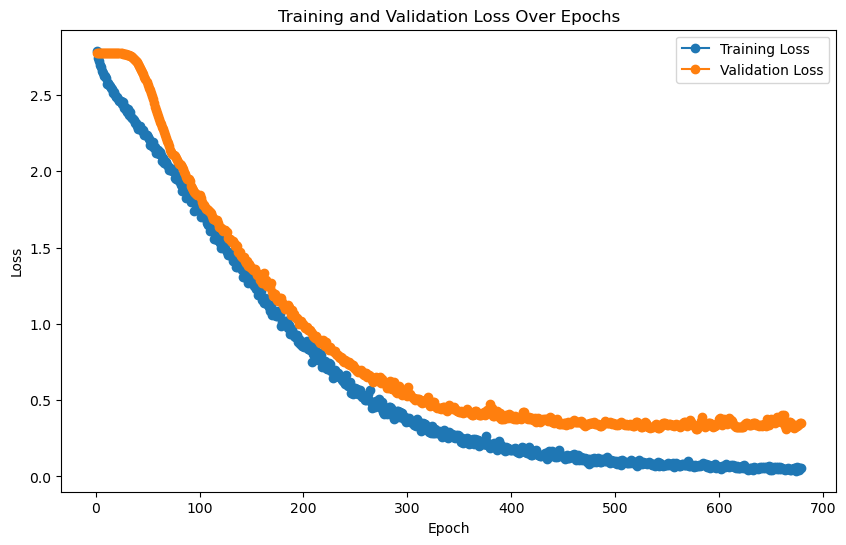

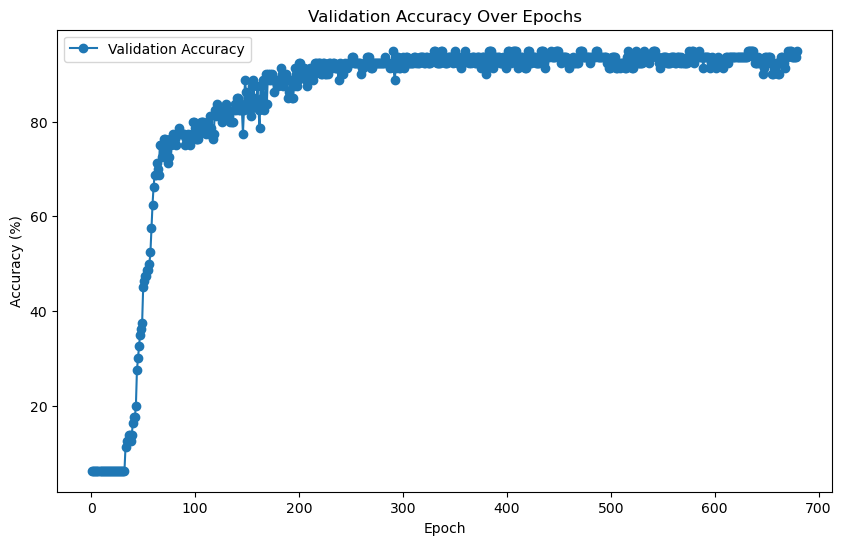


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.4478



Final Test Loss: 0.5262, Test Accuracy: 86.14%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.


  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.


  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.
  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.


  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53889, 64), Test labels shape: (53889,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 85.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       0.71      1.00      0.83         5
           7       0.67      0.40      0.50         5
           8       0.67      0.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53889, 64)
Test labels shape: (53889,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0312  |  Val Loss: 2.8760
Validation loss improved from inf to 2.8760.
[Epoch 2/1000] Train Loss: 2.8317  |  Val Loss: 2.7701
Validation loss improved from 2.8760 to 2.7701.
[Epoch 3/1000] Train Loss: 2.7288  |  Val Loss: 2.6908
Validation loss improved from 2.7701 to 2.6908.
[Epoch 4/1000] Train Loss: 2.6546  |  Val Loss: 2.6190
Validation loss improved from 2.6908 to 2.6190.
[Epoch 5/1000] Train Loss: 2.5732  |  Val Loss: 2.5460
Validation loss improved from 2.6190 to 2.5460.
[Epoch 6/1000] Train Loss: 2.5028  |  Val Loss: 2.4771
Validation loss improved from 2.5460 to 2.4771.
[Epoch 7/1000] Train Loss: 2.4314  |  Val Loss: 2.4168
Validation loss improved from 2.4771 to 2.4168.
[Epoch 8/1000] Train Loss: 2.3669  |  Val Loss: 2.3548
Validation loss improved from 2.4168 to 2.3548.
[Epoch 9/1000] Train Loss: 2.3004  |  Val Loss: 2.2887
Validation loss improved from 2.3548 to 2.2887.
[Epoch 10/1000] Train Loss: 2.2300  |  Val Loss: 2.2171
Validation loss impr

[Epoch 20/1000] Train Loss: 1.4071  |  Val Loss: 1.4179
Validation loss improved from 1.4952 to 1.4179.
[Epoch 21/1000] Train Loss: 1.3265  |  Val Loss: 1.3473
Validation loss improved from 1.4179 to 1.3473.
[Epoch 22/1000] Train Loss: 1.2572  |  Val Loss: 1.2823
Validation loss improved from 1.3473 to 1.2823.
[Epoch 23/1000] Train Loss: 1.1858  |  Val Loss: 1.2200
Validation loss improved from 1.2823 to 1.2200.
[Epoch 24/1000] Train Loss: 1.1252  |  Val Loss: 1.1644
Validation loss improved from 1.2200 to 1.1644.
[Epoch 25/1000] Train Loss: 1.0662  |  Val Loss: 1.1031
Validation loss improved from 1.1644 to 1.1031.
[Epoch 26/1000] Train Loss: 1.0169  |  Val Loss: 1.0533
Validation loss improved from 1.1031 to 1.0533.
[Epoch 27/1000] Train Loss: 0.9661  |  Val Loss: 1.0118
Validation loss improved from 1.0533 to 1.0118.
[Epoch 28/1000] Train Loss: 0.9189  |  Val Loss: 0.9808
Validation loss improved from 1.0118 to 0.9808.
[Epoch 29/1000] Train Loss: 0.8771  |  Val Loss: 0.9432
Validati

[Epoch 31/1000] Train Loss: 0.8043  |  Val Loss: 0.8869
Validation loss improved from 0.9096 to 0.8869.
[Epoch 32/1000] Train Loss: 0.7699  |  Val Loss: 0.8548
Validation loss improved from 0.8869 to 0.8548.
[Epoch 33/1000] Train Loss: 0.7418  |  Val Loss: 0.8278
Validation loss improved from 0.8548 to 0.8278.
[Epoch 34/1000] Train Loss: 0.7109  |  Val Loss: 0.8070
Validation loss improved from 0.8278 to 0.8070.
[Epoch 35/1000] Train Loss: 0.6837  |  Val Loss: 0.7881
Validation loss improved from 0.8070 to 0.7881.
[Epoch 36/1000] Train Loss: 0.6613  |  Val Loss: 0.7630
Validation loss improved from 0.7881 to 0.7630.
[Epoch 37/1000] Train Loss: 0.6360  |  Val Loss: 0.7407
Validation loss improved from 0.7630 to 0.7407.
[Epoch 38/1000] Train Loss: 0.6281  |  Val Loss: 0.7235
Validation loss improved from 0.7407 to 0.7235.
[Epoch 39/1000] Train Loss: 0.6018  |  Val Loss: 0.7153
Validation loss improved from 0.7235 to 0.7153.
[Epoch 40/1000] Train Loss: 0.5875  |  Val Loss: 0.6912
Validati

[Epoch 50/1000] Train Loss: 0.4534  |  Val Loss: 0.6068
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.4480  |  Val Loss: 0.5841
Validation loss improved from 0.6018 to 0.5841.
[Epoch 52/1000] Train Loss: 0.4312  |  Val Loss: 0.5777
Validation loss improved from 0.5841 to 0.5777.
[Epoch 53/1000] Train Loss: 0.4258  |  Val Loss: 0.5718
Validation loss improved from 0.5777 to 0.5718.
[Epoch 54/1000] Train Loss: 0.4164  |  Val Loss: 0.5726
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 0.4054  |  Val Loss: 0.5725
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 0.4006  |  Val Loss: 0.5646
Validation loss improved from 0.5718 to 0.5646.
[Epoch 57/1000] Train Loss: 0.3945  |  Val Loss: 0.5534
Validation loss improved from 0.5646 to 0.5534.
[Epoch 58/1000] Train Loss: 0.3837  |  Val Loss: 0.5372
Validation loss improved from 0.5534 to 0.5372.
[Epoch 59/1000] Train Loss: 0.3713  |  Val Los

[Epoch 61/1000] Train Loss: 0.3590  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 0.3537  |  Val Loss: 0.5347
Validation loss improved from 0.5355 to 0.5347.
[Epoch 63/1000] Train Loss: 0.3457  |  Val Loss: 0.5309
Validation loss improved from 0.5347 to 0.5309.
[Epoch 64/1000] Train Loss: 0.3435  |  Val Loss: 0.5231
Validation loss improved from 0.5309 to 0.5231.
[Epoch 65/1000] Train Loss: 0.3308  |  Val Loss: 0.5299
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 0.3285  |  Val Loss: 0.5320
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 67/1000] Train Loss: 0.3259  |  Val Loss: 0.5072
Validation loss improved from 0.5231 to 0.5072.
[Epoch 68/1000] Train Loss: 0.3172  |  Val Loss: 0.4998
Validation loss improved from 0.5072 to 0.4998.
[Epoch 69/1000] Train Loss: 0.3186  |  Val Loss: 0.5141
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 70/1000] Train Loss: 0.3067  |  V

[Epoch 80/1000] Train Loss: 0.2626  |  Val Loss: 0.5170
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 81/1000] Train Loss: 0.2644  |  Val Loss: 0.5110
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 82/1000] Train Loss: 0.2571  |  Val Loss: 0.5141
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 83/1000] Train Loss: 0.2619  |  Val Loss: 0.5224
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 84/1000] Train Loss: 0.2426  |  Val Loss: 0.5061
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 85/1000] Train Loss: 0.2421  |  Val Loss: 0.5163
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 86/1000] Train Loss: 0.2348  |  Val Loss: 0.5356
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 87/1000] Train Loss: 0.2334  |  Val Loss: 0.5283
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 88/1000] Train Loss: 0.2248  |  Val Loss: 0.5098
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 89/1000] Train Loss: 0.2333  |  Val Loss: 0.5093
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 90/1000] Train Loss: 0.2226  |  Val Loss: 0.5244
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 91/1000] Train Loss: 0.2231  |  Val Loss: 0.5406
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 92/1000] Train Loss: 0.2179  |  Val Loss: 0.5227
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 93/1000] Train Loss: 0.2195  |  Val Loss: 0.5203
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 94/1000] Train Loss: 0.2195  |  Val Loss: 0.5322
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 95/1000] Train Loss: 0.2067  |  Val Loss: 0.5209
!! Validation loss did NOT improve !! Patience: 27/100
[

[Epoch 104/1000] Train Loss: 0.1878  |  Val Loss: 0.5249
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 105/1000] Train Loss: 0.1871  |  Val Loss: 0.5312
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 106/1000] Train Loss: 0.1855  |  Val Loss: 0.5463
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 107/1000] Train Loss: 0.1808  |  Val Loss: 0.5442
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 108/1000] Train Loss: 0.1779  |  Val Loss: 0.5478
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 109/1000] Train Loss: 0.1759  |  Val Loss: 0.5529
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 110/1000] Train Loss: 0.1714  |  Val Loss: 0.5730
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 111/1000] Train Loss: 0.1725  |  Val Loss: 0.5796
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 112/1000] Train Loss: 0.1706  |  Val Loss: 0.5664
!! Validation loss did NOT improve !! Patience:

[Epoch 114/1000] Train Loss: 0.1677  |  Val Loss: 0.5528
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 115/1000] Train Loss: 0.1667  |  Val Loss: 0.5603
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 116/1000] Train Loss: 0.1606  |  Val Loss: 0.5740
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 117/1000] Train Loss: 0.1638  |  Val Loss: 0.5627
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 118/1000] Train Loss: 0.1594  |  Val Loss: 0.5641
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 119/1000] Train Loss: 0.1656  |  Val Loss: 0.5720
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 120/1000] Train Loss: 0.1524  |  Val Loss: 0.6001
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 121/1000] Train Loss: 0.1649  |  Val Loss: 0.5981
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 122/1000] Train Loss: 0.1564  |  Val Loss: 0.5870
!! Validation loss did NOT improve !! Patience:

[Epoch 133/1000] Train Loss: 0.1316  |  Val Loss: 0.6182
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 134/1000] Train Loss: 0.1351  |  Val Loss: 0.6247
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 135/1000] Train Loss: 0.1309  |  Val Loss: 0.6427
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 136/1000] Train Loss: 0.1288  |  Val Loss: 0.6522
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 137/1000] Train Loss: 0.1292  |  Val Loss: 0.6405
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 138/1000] Train Loss: 0.1281  |  Val Loss: 0.6461
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 139/1000] Train Loss: 0.1272  |  Val Loss: 0.6385
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 140/1000] Train Loss: 0.1314  |  Val Loss: 0.6481
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 141/1000] Train Loss: 0.1251  |  Val Loss: 0.6408
!! Validation loss did NOT improve !! Patience:

[Epoch 143/1000] Train Loss: 0.1225  |  Val Loss: 0.6695
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 144/1000] Train Loss: 0.1293  |  Val Loss: 0.6868
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 145/1000] Train Loss: 0.1266  |  Val Loss: 0.6626
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 146/1000] Train Loss: 0.1216  |  Val Loss: 0.6521
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 147/1000] Train Loss: 0.1222  |  Val Loss: 0.6772
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 148/1000] Train Loss: 0.1170  |  Val Loss: 0.6818
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 149/1000] Train Loss: 0.1157  |  Val Loss: 0.6718
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 150/1000] Train Loss: 0.1151  |  Val Loss: 0.6697
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 151/1000] Train Loss: 0.1164  |  Val Loss: 0.6916
!! Validation loss did NOT improve !! Patience:

[Epoch 162/1000] Train Loss: 0.1072  |  Val Loss: 0.7189
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 163/1000] Train Loss: 0.1032  |  Val Loss: 0.7477
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 164/1000] Train Loss: 0.1106  |  Val Loss: 0.7718
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 165/1000] Train Loss: 0.1051  |  Val Loss: 0.7407
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 166/1000] Train Loss: 0.1050  |  Val Loss: 0.7271
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 167/1000] Train Loss: 0.1009  |  Val Loss: 0.7376
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 168/1000] Train Loss: 0.1104  |  Val Loss: 0.7711
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 168 !!
No improvement for 100 epochs.


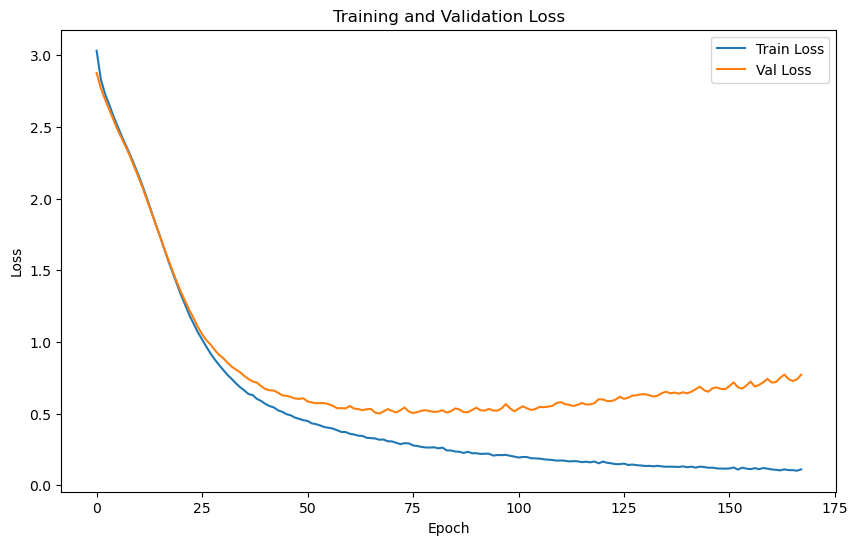

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.8002 | Test Accuracy: 78.28%


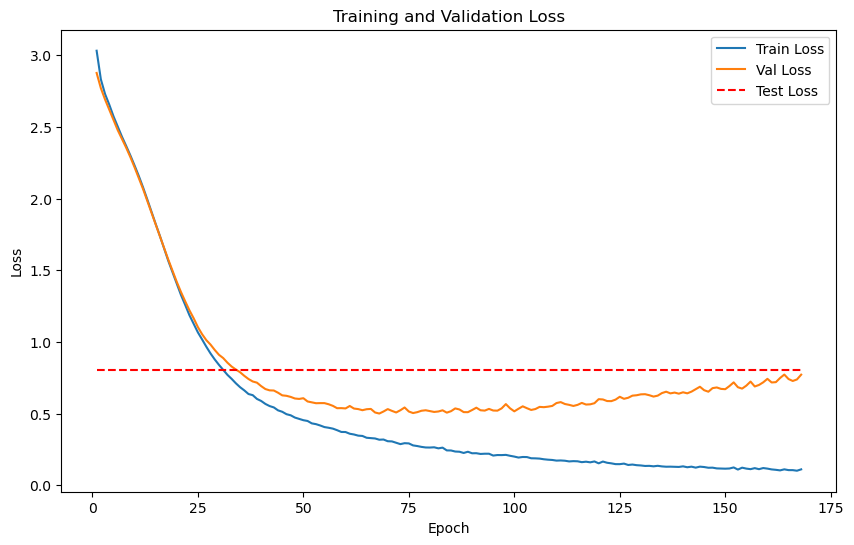

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.6656
Epoch [1/2000], Avg Train Loss: 7.6656


Epoch [1/2000], Avg Val Loss: 2.9138
Validation loss improved from inf to 2.9138. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.6355
Epoch [2/2000], Avg Train Loss: 7.6355
Epoch [2/2000], Avg Val Loss: 2.9028
Validation loss improved from 2.9138 to 2.9028. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.5634
Epoch [3/2000], Avg Train Loss: 7.5634
Epoch [3/2000], Avg Val Loss: 2.8922
Validation loss improved from 2.9028 to 2.8922. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.4718
Epoch [4/2000], Avg Train Loss: 7.4718
Epoch [4/2000], Avg Val Loss: 2.8820
Validation loss improved from 2.8922 to 2.8820. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.5296
Epoch [5/2000], Avg Train Loss: 7.5296
Epoch [5/2000], Avg Val Loss: 2.8722
Validation loss improved from 2.8820 to 2.8722. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.0623
Ep

Epoch [19/2000], Avg Val Loss: 2.7753
Validation loss improved from 2.7800 to 2.7753. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.3229
Epoch [20/2000], Avg Train Loss: 6.3229
Epoch [20/2000], Avg Val Loss: 2.7709
Validation loss improved from 2.7753 to 2.7709. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.3368
Epoch [21/2000], Avg Train Loss: 6.3368
Epoch [21/2000], Avg Val Loss: 2.7668
Validation loss improved from 2.7709 to 2.7668. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.1478
Epoch [22/2000], Avg Train Loss: 6.1478
Epoch [22/2000], Avg Val Loss: 2.7629
Validation loss improved from 2.7668 to 2.7629. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.2707
Epoch [23/2000], Avg Train Loss: 6.2707
Epoch [23/2000], Avg Val Loss: 2.7593
Validation loss improved from 2.7629 to 2.7593. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.3480
Epoch [44/2000], Avg Train Loss: 5.3480
Epoch [44/2000], Avg Val Loss: 2.7286
Validation loss improved from 2.7286 to 2.7286. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.2261
Epoch [45/2000], Avg Train Loss: 5.2261
Epoch [45/2000], Avg Val Loss: 2.7286
Validation loss did not improve. Patience: 1/100

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.2749
Epoch [46/2000], Avg Train Loss: 5.2749
Epoch [46/2000], Avg Val Loss: 2.7287
Validation loss did not improve. Patience: 2/100

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.2931
Epoch [47/2000], Avg Train Loss: 5.2931
Epoch [47/2000], Avg Val Loss: 2.7289
Validation loss did not improve. Patience: 3/100

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.1355
Epoch [48/2000], Avg Train Loss: 5.1355
Epoch [48/2000], Avg Val Loss: 2.7292
Validation loss did not improve. Patience: 4/100

LOG: Epoch [49/2000] - Training
    B

    Batch [1/1], Train Loss: 4.9778
Epoch [60/2000], Avg Train Loss: 4.9778
Epoch [60/2000], Avg Val Loss: 2.7367
Validation loss did not improve. Patience: 16/100

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 4.9027
Epoch [61/2000], Avg Train Loss: 4.9027
Epoch [61/2000], Avg Val Loss: 2.7375
Validation loss did not improve. Patience: 17/100

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 4.8507
Epoch [62/2000], Avg Train Loss: 4.8507
Epoch [62/2000], Avg Val Loss: 2.7383
Validation loss did not improve. Patience: 18/100

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 4.8660
Epoch [63/2000], Avg Train Loss: 4.8660
Epoch [63/2000], Avg Val Loss: 2.7392
Validation loss did not improve. Patience: 19/100

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 4.9085
Epoch [64/2000], Avg Train Loss: 4.9085
Epoch [64/2000], Avg Val Loss: 2.7401
Validation loss did not improve. Patience: 20/100

LOG: Epoch [65/2000] - Training
    Batch [1/1]

Epoch [83/2000], Avg Val Loss: 2.7559
Validation loss did not improve. Patience: 39/100

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 4.5533
Epoch [84/2000], Avg Train Loss: 4.5533
Epoch [84/2000], Avg Val Loss: 2.7566
Validation loss did not improve. Patience: 40/100

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 4.5640
Epoch [85/2000], Avg Train Loss: 4.5640
Epoch [85/2000], Avg Val Loss: 2.7572
Validation loss did not improve. Patience: 41/100

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 4.4336
Epoch [86/2000], Avg Train Loss: 4.4336
Epoch [86/2000], Avg Val Loss: 2.7578
Validation loss did not improve. Patience: 42/100

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 4.5214
Epoch [87/2000], Avg Train Loss: 4.5214
Epoch [87/2000], Avg Val Loss: 2.7583
Validation loss did not improve. Patience: 43/100

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.5346
Epoch [88/2000], Avg Train Loss: 4.5346
Epoch [88/2000]

    Batch [1/1], Train Loss: 4.3380
Epoch [103/2000], Avg Train Loss: 4.3380
Epoch [103/2000], Avg Val Loss: 2.7642
Validation loss did not improve. Patience: 59/100

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.3943
Epoch [104/2000], Avg Train Loss: 4.3943
Epoch [104/2000], Avg Val Loss: 2.7644
Validation loss did not improve. Patience: 60/100

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.3687
Epoch [105/2000], Avg Train Loss: 4.3687
Epoch [105/2000], Avg Val Loss: 2.7646
Validation loss did not improve. Patience: 61/100

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.4363
Epoch [106/2000], Avg Train Loss: 4.4363
Epoch [106/2000], Avg Val Loss: 2.7648
Validation loss did not improve. Patience: 62/100

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.3426
Epoch [107/2000], Avg Train Loss: 4.3426
Epoch [107/2000], Avg Val Loss: 2.7649
Validation loss did not improve. Patience: 63/100

LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 4.2040
Epoch [123/2000], Avg Train Loss: 4.2040
Epoch [123/2000], Avg Val Loss: 2.7638
Validation loss did not improve. Patience: 79/100

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 4.3154
Epoch [124/2000], Avg Train Loss: 4.3154
Epoch [124/2000], Avg Val Loss: 2.7636
Validation loss did not improve. Patience: 80/100

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.2717
Epoch [125/2000], Avg Train Loss: 4.2717
Epoch [125/2000], Avg Val Loss: 2.7633
Validation loss did not improve. Patience: 81/100

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.2080
Epoch [126/2000], Avg Train Loss: 4.2080
Epoch [126/2000], Avg Val Loss: 2.7630
Validation loss did not improve. Patience: 82/100

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.2275
Epoch [127/2000], Avg Train Loss: 4.2275
Epoch [127/2000], Avg Val Loss: 2.7627
Validation loss did not improve. Patience: 83/100

LOG: Epoch [128/2000] - Training


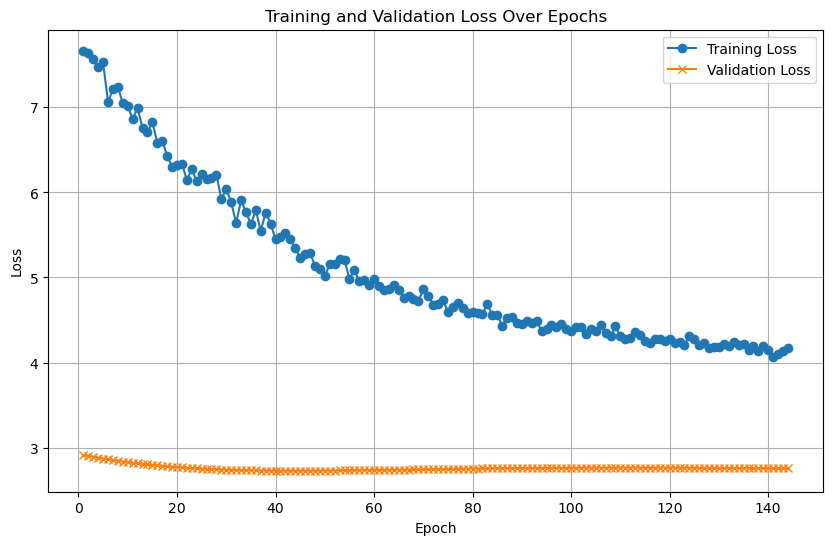

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 4.6747


Test Batch [20/211], Loss: 4.9137
Test Batch [30/211], Loss: 4.8838
Test Batch [40/211], Loss: 4.9980
Test Batch [50/211], Loss: 4.7465
Test Batch [60/211], Loss: 4.8191
Test Batch [70/211], Loss: 4.7312
Test Batch [80/211], Loss: 4.8457
Test Batch [90/211], Loss: 4.4782
Test Batch [100/211], Loss: 4.5719
Test Batch [110/211], Loss: 4.7492
Test Batch [120/211], Loss: 5.0635
Test Batch [130/211], Loss: 4.6014
Test Batch [140/211], Loss: 4.5836
Test Batch [150/211], Loss: 4.5926


Test Batch [160/211], Loss: 4.7084
Test Batch [170/211], Loss: 4.6259
Test Batch [180/211], Loss: 4.8064
Test Batch [190/211], Loss: 4.7729
Test Batch [200/211], Loss: 4.7149
Test Batch [210/211], Loss: 4.6774

Test Loss: 4.7554


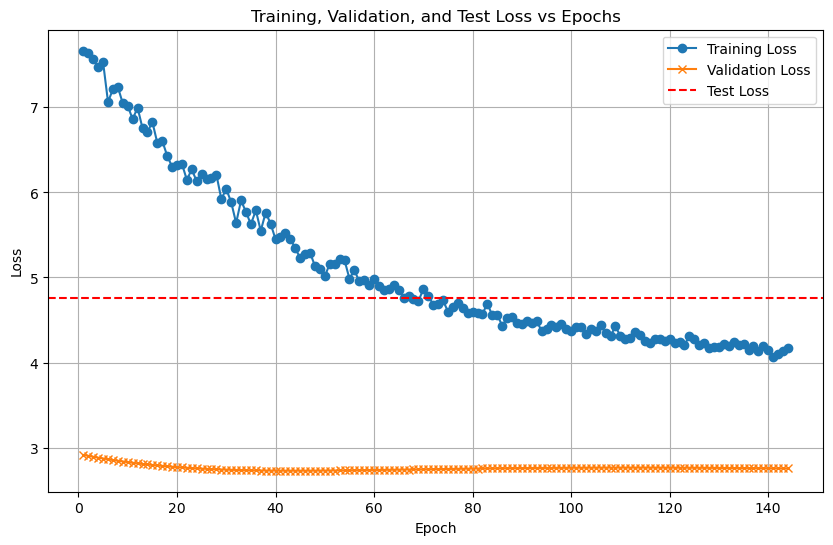

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.


  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.


  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.


  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 76.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.20      0.33         5
           3       1.00      1.00      1.00         5
           4       0.71      1.00      0.83         5
           5       1.00      1.00      1.00         5
           6       0.56      1.00      0.71         5
           7       0.67      0.40      0.50         5
           8       0.50      0.80      0.62         5
           9       0.67      0.40      0.50         5
          10       0.75      0.60      0.67         5
          11       0.71      1.00      0.83         5
          12       0.83      1.00      0.91         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7945  |  Val Loss: 2.7807
Validation loss improved from inf to 2.7807.
[Epoch 2/1000] Train Loss: 2.7852  |  Val Loss: 2.7726
Validation loss improved from 2.7807 to 2.7726.
[Epoch 3/1000] Train Loss: 2.7776  |  Val Loss: 2.7649
Validation loss improved from 2.7726 to 2.7649.
[Epoch 4/1000] Train Loss: 2.7694  |  Val Loss: 2.7571
Validation loss improved from 2.7649 to 2.7571.
[Epoch 5/1000] Train Loss: 2.7621  |  Val Loss: 2.7498
Validation loss improved from 2.7571 to 2.7498.
[Epoch 6/1000] Train Loss: 2.7545  |  Val Loss: 2.7429
Validation loss improved from 2.7498 to 2.7429.
[Epoch 7/1000] Train Loss: 2.7475  |  Val Loss: 2.7363
Validation loss improved from 2.7429 to 2.7363.
[Epoch 8/1000] Train Loss: 2.7407  |  Val Loss: 2.7298
Validation loss improved from 2.7363 to 2.7298.
[Epoch 9/1000] Train Loss: 2.7344  |  Val Loss: 2.7236
Validation loss improved from 2.7298 to 2.7236.
[Epoch 10/1000] Train Loss: 2.7279  |  Val Loss: 2.7174
Validation loss impr

[Epoch 27/1000] Train Loss: 2.6208  |  Val Loss: 2.6112
Validation loss improved from 2.6179 to 2.6112.
[Epoch 28/1000] Train Loss: 2.6130  |  Val Loss: 2.6045
Validation loss improved from 2.6112 to 2.6045.
[Epoch 29/1000] Train Loss: 2.6065  |  Val Loss: 2.5977
Validation loss improved from 2.6045 to 2.5977.
[Epoch 30/1000] Train Loss: 2.5993  |  Val Loss: 2.5908
Validation loss improved from 2.5977 to 2.5908.
[Epoch 31/1000] Train Loss: 2.5917  |  Val Loss: 2.5835
Validation loss improved from 2.5908 to 2.5835.
[Epoch 32/1000] Train Loss: 2.5838  |  Val Loss: 2.5759
Validation loss improved from 2.5835 to 2.5759.
[Epoch 33/1000] Train Loss: 2.5757  |  Val Loss: 2.5681
Validation loss improved from 2.5759 to 2.5681.


[Epoch 34/1000] Train Loss: 2.5674  |  Val Loss: 2.5604
Validation loss improved from 2.5681 to 2.5604.
[Epoch 35/1000] Train Loss: 2.5596  |  Val Loss: 2.5528
Validation loss improved from 2.5604 to 2.5528.
[Epoch 36/1000] Train Loss: 2.5517  |  Val Loss: 2.5452
Validation loss improved from 2.5528 to 2.5452.
[Epoch 37/1000] Train Loss: 2.5438  |  Val Loss: 2.5373
Validation loss improved from 2.5452 to 2.5373.
[Epoch 38/1000] Train Loss: 2.5361  |  Val Loss: 2.5293
Validation loss improved from 2.5373 to 2.5293.
[Epoch 39/1000] Train Loss: 2.5276  |  Val Loss: 2.5214
Validation loss improved from 2.5293 to 2.5214.
[Epoch 40/1000] Train Loss: 2.5195  |  Val Loss: 2.5134
Validation loss improved from 2.5214 to 2.5134.
[Epoch 41/1000] Train Loss: 2.5115  |  Val Loss: 2.5053
Validation loss improved from 2.5134 to 2.5053.
[Epoch 42/1000] Train Loss: 2.5030  |  Val Loss: 2.4972
Validation loss improved from 2.5053 to 2.4972.
[Epoch 43/1000] Train Loss: 2.4950  |  Val Loss: 2.4892
Validati

[Epoch 54/1000] Train Loss: 2.4024  |  Val Loss: 2.3975
Validation loss improved from 2.4065 to 2.3975.
[Epoch 55/1000] Train Loss: 2.3934  |  Val Loss: 2.3889
Validation loss improved from 2.3975 to 2.3889.
[Epoch 56/1000] Train Loss: 2.3847  |  Val Loss: 2.3799
Validation loss improved from 2.3889 to 2.3799.
[Epoch 57/1000] Train Loss: 2.3757  |  Val Loss: 2.3707
Validation loss improved from 2.3799 to 2.3707.
[Epoch 58/1000] Train Loss: 2.3662  |  Val Loss: 2.3615
Validation loss improved from 2.3707 to 2.3615.
[Epoch 59/1000] Train Loss: 2.3573  |  Val Loss: 2.3518
Validation loss improved from 2.3615 to 2.3518.


[Epoch 60/1000] Train Loss: 2.3479  |  Val Loss: 2.3419
Validation loss improved from 2.3518 to 2.3419.
[Epoch 61/1000] Train Loss: 2.3375  |  Val Loss: 2.3317
Validation loss improved from 2.3419 to 2.3317.
[Epoch 62/1000] Train Loss: 2.3275  |  Val Loss: 2.3211
Validation loss improved from 2.3317 to 2.3211.
[Epoch 63/1000] Train Loss: 2.3173  |  Val Loss: 2.3104
Validation loss improved from 2.3211 to 2.3104.
[Epoch 64/1000] Train Loss: 2.3070  |  Val Loss: 2.2997
Validation loss improved from 2.3104 to 2.2997.
[Epoch 65/1000] Train Loss: 2.2963  |  Val Loss: 2.2890
Validation loss improved from 2.2997 to 2.2890.
[Epoch 66/1000] Train Loss: 2.2858  |  Val Loss: 2.2782
Validation loss improved from 2.2890 to 2.2782.
[Epoch 67/1000] Train Loss: 2.2754  |  Val Loss: 2.2672
Validation loss improved from 2.2782 to 2.2672.
[Epoch 68/1000] Train Loss: 2.2649  |  Val Loss: 2.2564
Validation loss improved from 2.2672 to 2.2564.
[Epoch 69/1000] Train Loss: 2.2539  |  Val Loss: 2.2457
Validati

[Epoch 79/1000] Train Loss: 2.1417  |  Val Loss: 2.1356
Validation loss improved from 2.1472 to 2.1356.
[Epoch 80/1000] Train Loss: 2.1302  |  Val Loss: 2.1241
Validation loss improved from 2.1356 to 2.1241.
[Epoch 81/1000] Train Loss: 2.1186  |  Val Loss: 2.1131
Validation loss improved from 2.1241 to 2.1131.
[Epoch 82/1000] Train Loss: 2.1073  |  Val Loss: 2.1023
Validation loss improved from 2.1131 to 2.1023.
[Epoch 83/1000] Train Loss: 2.0958  |  Val Loss: 2.0918
Validation loss improved from 2.1023 to 2.0918.
[Epoch 84/1000] Train Loss: 2.0849  |  Val Loss: 2.0812
Validation loss improved from 2.0918 to 2.0812.


[Epoch 85/1000] Train Loss: 2.0742  |  Val Loss: 2.0702
Validation loss improved from 2.0812 to 2.0702.
[Epoch 86/1000] Train Loss: 2.0626  |  Val Loss: 2.0593
Validation loss improved from 2.0702 to 2.0593.
[Epoch 87/1000] Train Loss: 2.0517  |  Val Loss: 2.0483
Validation loss improved from 2.0593 to 2.0483.
[Epoch 88/1000] Train Loss: 2.0403  |  Val Loss: 2.0375
Validation loss improved from 2.0483 to 2.0375.
[Epoch 89/1000] Train Loss: 2.0289  |  Val Loss: 2.0268
Validation loss improved from 2.0375 to 2.0268.
[Epoch 90/1000] Train Loss: 2.0178  |  Val Loss: 2.0161
Validation loss improved from 2.0268 to 2.0161.
[Epoch 91/1000] Train Loss: 2.0072  |  Val Loss: 2.0055
Validation loss improved from 2.0161 to 2.0055.
[Epoch 92/1000] Train Loss: 1.9955  |  Val Loss: 1.9951
Validation loss improved from 2.0055 to 1.9951.
[Epoch 93/1000] Train Loss: 1.9845  |  Val Loss: 1.9847
Validation loss improved from 1.9951 to 1.9847.
[Epoch 94/1000] Train Loss: 1.9736  |  Val Loss: 1.9742
Validati

[Epoch 109/1000] Train Loss: 1.8172  |  Val Loss: 1.8249
Validation loss improved from 1.8346 to 1.8249.
[Epoch 110/1000] Train Loss: 1.8074  |  Val Loss: 1.8153
Validation loss improved from 1.8249 to 1.8153.
[Epoch 111/1000] Train Loss: 1.7975  |  Val Loss: 1.8057
Validation loss improved from 1.8153 to 1.8057.
[Epoch 112/1000] Train Loss: 1.7875  |  Val Loss: 1.7965
Validation loss improved from 1.8057 to 1.7965.
[Epoch 113/1000] Train Loss: 1.7774  |  Val Loss: 1.7874
Validation loss improved from 1.7965 to 1.7874.
[Epoch 114/1000] Train Loss: 1.7676  |  Val Loss: 1.7782
Validation loss improved from 1.7874 to 1.7782.
[Epoch 115/1000] Train Loss: 1.7578  |  Val Loss: 1.7692
Validation loss improved from 1.7782 to 1.7692.


[Epoch 116/1000] Train Loss: 1.7483  |  Val Loss: 1.7604
Validation loss improved from 1.7692 to 1.7604.
[Epoch 117/1000] Train Loss: 1.7388  |  Val Loss: 1.7512
Validation loss improved from 1.7604 to 1.7512.
[Epoch 118/1000] Train Loss: 1.7288  |  Val Loss: 1.7421
Validation loss improved from 1.7512 to 1.7421.
[Epoch 119/1000] Train Loss: 1.7191  |  Val Loss: 1.7328
Validation loss improved from 1.7421 to 1.7328.
[Epoch 120/1000] Train Loss: 1.7097  |  Val Loss: 1.7233
Validation loss improved from 1.7328 to 1.7233.
[Epoch 121/1000] Train Loss: 1.7000  |  Val Loss: 1.7143
Validation loss improved from 1.7233 to 1.7143.
[Epoch 122/1000] Train Loss: 1.6908  |  Val Loss: 1.7056
Validation loss improved from 1.7143 to 1.7056.
[Epoch 123/1000] Train Loss: 1.6813  |  Val Loss: 1.6972
Validation loss improved from 1.7056 to 1.6972.
[Epoch 124/1000] Train Loss: 1.6721  |  Val Loss: 1.6891
Validation loss improved from 1.6972 to 1.6891.
[Epoch 125/1000] Train Loss: 1.6631  |  Val Loss: 1.680

[Epoch 140/1000] Train Loss: 1.5322  |  Val Loss: 1.5626
Validation loss improved from 1.5705 to 1.5626.
[Epoch 141/1000] Train Loss: 1.5240  |  Val Loss: 1.5543
Validation loss improved from 1.5626 to 1.5543.
[Epoch 142/1000] Train Loss: 1.5160  |  Val Loss: 1.5465
Validation loss improved from 1.5543 to 1.5465.
[Epoch 143/1000] Train Loss: 1.5077  |  Val Loss: 1.5388
Validation loss improved from 1.5465 to 1.5388.
[Epoch 144/1000] Train Loss: 1.4993  |  Val Loss: 1.5310
Validation loss improved from 1.5388 to 1.5310.
[Epoch 145/1000] Train Loss: 1.4913  |  Val Loss: 1.5232
Validation loss improved from 1.5310 to 1.5232.


[Epoch 146/1000] Train Loss: 1.4833  |  Val Loss: 1.5155
Validation loss improved from 1.5232 to 1.5155.
[Epoch 147/1000] Train Loss: 1.4754  |  Val Loss: 1.5081
Validation loss improved from 1.5155 to 1.5081.
[Epoch 148/1000] Train Loss: 1.4675  |  Val Loss: 1.5005
Validation loss improved from 1.5081 to 1.5005.
[Epoch 149/1000] Train Loss: 1.4597  |  Val Loss: 1.4935
Validation loss improved from 1.5005 to 1.4935.
[Epoch 150/1000] Train Loss: 1.4518  |  Val Loss: 1.4864
Validation loss improved from 1.4935 to 1.4864.
[Epoch 151/1000] Train Loss: 1.4438  |  Val Loss: 1.4801
Validation loss improved from 1.4864 to 1.4801.
[Epoch 152/1000] Train Loss: 1.4361  |  Val Loss: 1.4735
Validation loss improved from 1.4801 to 1.4735.
[Epoch 153/1000] Train Loss: 1.4284  |  Val Loss: 1.4666
Validation loss improved from 1.4735 to 1.4666.
[Epoch 154/1000] Train Loss: 1.4207  |  Val Loss: 1.4588
Validation loss improved from 1.4666 to 1.4588.
[Epoch 155/1000] Train Loss: 1.4132  |  Val Loss: 1.451

[Epoch 171/1000] Train Loss: 1.2956  |  Val Loss: 1.3377
Validation loss improved from 1.3444 to 1.3377.
[Epoch 172/1000] Train Loss: 1.2887  |  Val Loss: 1.3314
Validation loss improved from 1.3377 to 1.3314.
[Epoch 173/1000] Train Loss: 1.2821  |  Val Loss: 1.3247
Validation loss improved from 1.3314 to 1.3247.
[Epoch 174/1000] Train Loss: 1.2757  |  Val Loss: 1.3184
Validation loss improved from 1.3247 to 1.3184.
[Epoch 175/1000] Train Loss: 1.2684  |  Val Loss: 1.3117
Validation loss improved from 1.3184 to 1.3117.
[Epoch 176/1000] Train Loss: 1.2617  |  Val Loss: 1.3051
Validation loss improved from 1.3117 to 1.3051.
[Epoch 177/1000] Train Loss: 1.2550  |  Val Loss: 1.2987
Validation loss improved from 1.3051 to 1.2987.
[Epoch 178/1000] Train Loss: 1.2482  |  Val Loss: 1.2927
Validation loss improved from 1.2987 to 1.2927.


[Epoch 179/1000] Train Loss: 1.2418  |  Val Loss: 1.2866
Validation loss improved from 1.2927 to 1.2866.
[Epoch 180/1000] Train Loss: 1.2352  |  Val Loss: 1.2814
Validation loss improved from 1.2866 to 1.2814.
[Epoch 181/1000] Train Loss: 1.2285  |  Val Loss: 1.2758
Validation loss improved from 1.2814 to 1.2758.
[Epoch 182/1000] Train Loss: 1.2223  |  Val Loss: 1.2700
Validation loss improved from 1.2758 to 1.2700.
[Epoch 183/1000] Train Loss: 1.2158  |  Val Loss: 1.2638
Validation loss improved from 1.2700 to 1.2638.
[Epoch 184/1000] Train Loss: 1.2091  |  Val Loss: 1.2575
Validation loss improved from 1.2638 to 1.2575.
[Epoch 185/1000] Train Loss: 1.2025  |  Val Loss: 1.2510
Validation loss improved from 1.2575 to 1.2510.
[Epoch 186/1000] Train Loss: 1.1963  |  Val Loss: 1.2448
Validation loss improved from 1.2510 to 1.2448.
[Epoch 187/1000] Train Loss: 1.1899  |  Val Loss: 1.2385
Validation loss improved from 1.2448 to 1.2385.
[Epoch 188/1000] Train Loss: 1.1839  |  Val Loss: 1.232

[Epoch 196/1000] Train Loss: 1.1347  |  Val Loss: 1.1880
Validation loss improved from 1.1935 to 1.1880.
[Epoch 197/1000] Train Loss: 1.1288  |  Val Loss: 1.1826
Validation loss improved from 1.1880 to 1.1826.
[Epoch 198/1000] Train Loss: 1.1229  |  Val Loss: 1.1770
Validation loss improved from 1.1826 to 1.1770.
[Epoch 199/1000] Train Loss: 1.1168  |  Val Loss: 1.1713
Validation loss improved from 1.1770 to 1.1713.
[Epoch 200/1000] Train Loss: 1.1104  |  Val Loss: 1.1657
Validation loss improved from 1.1713 to 1.1657.
[Epoch 201/1000] Train Loss: 1.1044  |  Val Loss: 1.1600
Validation loss improved from 1.1657 to 1.1600.
[Epoch 202/1000] Train Loss: 1.0981  |  Val Loss: 1.1547
Validation loss improved from 1.1600 to 1.1547.
[Epoch 203/1000] Train Loss: 1.0921  |  Val Loss: 1.1492
Validation loss improved from 1.1547 to 1.1492.
[Epoch 204/1000] Train Loss: 1.0860  |  Val Loss: 1.1431
Validation loss improved from 1.1492 to 1.1431.
[Epoch 205/1000] Train Loss: 1.0799  |  Val Loss: 1.137

[Epoch 207/1000] Train Loss: 1.0680  |  Val Loss: 1.1277
Validation loss improved from 1.1325 to 1.1277.
[Epoch 208/1000] Train Loss: 1.0620  |  Val Loss: 1.1221
Validation loss improved from 1.1277 to 1.1221.
[Epoch 209/1000] Train Loss: 1.0562  |  Val Loss: 1.1169
Validation loss improved from 1.1221 to 1.1169.
[Epoch 210/1000] Train Loss: 1.0504  |  Val Loss: 1.1113
Validation loss improved from 1.1169 to 1.1113.
[Epoch 211/1000] Train Loss: 1.0447  |  Val Loss: 1.1061
Validation loss improved from 1.1113 to 1.1061.
[Epoch 212/1000] Train Loss: 1.0390  |  Val Loss: 1.1010
Validation loss improved from 1.1061 to 1.1010.
[Epoch 213/1000] Train Loss: 1.0337  |  Val Loss: 1.0967
Validation loss improved from 1.1010 to 1.0967.
[Epoch 214/1000] Train Loss: 1.0278  |  Val Loss: 1.0926
Validation loss improved from 1.0967 to 1.0926.
[Epoch 215/1000] Train Loss: 1.0225  |  Val Loss: 1.0878
Validation loss improved from 1.0926 to 1.0878.
[Epoch 216/1000] Train Loss: 1.0168  |  Val Loss: 1.082

[Epoch 221/1000] Train Loss: 0.9897  |  Val Loss: 1.0603
Validation loss improved from 1.0651 to 1.0603.
[Epoch 222/1000] Train Loss: 0.9844  |  Val Loss: 1.0552
Validation loss improved from 1.0603 to 1.0552.
[Epoch 223/1000] Train Loss: 0.9789  |  Val Loss: 1.0503
Validation loss improved from 1.0552 to 1.0503.
[Epoch 224/1000] Train Loss: 0.9736  |  Val Loss: 1.0452
Validation loss improved from 1.0503 to 1.0452.
[Epoch 225/1000] Train Loss: 0.9687  |  Val Loss: 1.0398
Validation loss improved from 1.0452 to 1.0398.
[Epoch 226/1000] Train Loss: 0.9631  |  Val Loss: 1.0350
Validation loss improved from 1.0398 to 1.0350.
[Epoch 227/1000] Train Loss: 0.9585  |  Val Loss: 1.0300
Validation loss improved from 1.0350 to 1.0300.
[Epoch 228/1000] Train Loss: 0.9533  |  Val Loss: 1.0254
Validation loss improved from 1.0300 to 1.0254.
[Epoch 229/1000] Train Loss: 0.9479  |  Val Loss: 1.0212
Validation loss improved from 1.0254 to 1.0212.
[Epoch 230/1000] Train Loss: 0.9428  |  Val Loss: 1.016

[Epoch 237/1000] Train Loss: 0.9078  |  Val Loss: 0.9845
Validation loss improved from 0.9891 to 0.9845.
[Epoch 238/1000] Train Loss: 0.9027  |  Val Loss: 0.9801
Validation loss improved from 0.9845 to 0.9801.
[Epoch 239/1000] Train Loss: 0.8979  |  Val Loss: 0.9763
Validation loss improved from 0.9801 to 0.9763.
[Epoch 240/1000] Train Loss: 0.8931  |  Val Loss: 0.9724
Validation loss improved from 0.9763 to 0.9724.
[Epoch 241/1000] Train Loss: 0.8883  |  Val Loss: 0.9694
Validation loss improved from 0.9724 to 0.9694.
[Epoch 242/1000] Train Loss: 0.8833  |  Val Loss: 0.9663
Validation loss improved from 0.9694 to 0.9663.
[Epoch 243/1000] Train Loss: 0.8787  |  Val Loss: 0.9631
Validation loss improved from 0.9663 to 0.9631.
[Epoch 244/1000] Train Loss: 0.8739  |  Val Loss: 0.9594
Validation loss improved from 0.9631 to 0.9594.
[Epoch 245/1000] Train Loss: 0.8695  |  Val Loss: 0.9556
Validation loss improved from 0.9594 to 0.9556.
[Epoch 246/1000] Train Loss: 0.8645  |  Val Loss: 0.951

[Epoch 250/1000] Train Loss: 0.8463  |  Val Loss: 0.9360
Validation loss improved from 0.9406 to 0.9360.
[Epoch 251/1000] Train Loss: 0.8418  |  Val Loss: 0.9318
Validation loss improved from 0.9360 to 0.9318.
[Epoch 252/1000] Train Loss: 0.8376  |  Val Loss: 0.9278
Validation loss improved from 0.9318 to 0.9278.
[Epoch 253/1000] Train Loss: 0.8334  |  Val Loss: 0.9234
Validation loss improved from 0.9278 to 0.9234.
[Epoch 254/1000] Train Loss: 0.8289  |  Val Loss: 0.9195
Validation loss improved from 0.9234 to 0.9195.
[Epoch 255/1000] Train Loss: 0.8247  |  Val Loss: 0.9160
Validation loss improved from 0.9195 to 0.9160.
[Epoch 256/1000] Train Loss: 0.8204  |  Val Loss: 0.9125
Validation loss improved from 0.9160 to 0.9125.
[Epoch 257/1000] Train Loss: 0.8159  |  Val Loss: 0.9088
Validation loss improved from 0.9125 to 0.9088.
[Epoch 258/1000] Train Loss: 0.8116  |  Val Loss: 0.9055
Validation loss improved from 0.9088 to 0.9055.
[Epoch 259/1000] Train Loss: 0.8076  |  Val Loss: 0.902

[Epoch 267/1000] Train Loss: 0.7759  |  Val Loss: 0.8782
Validation loss improved from 0.8810 to 0.8782.
[Epoch 268/1000] Train Loss: 0.7720  |  Val Loss: 0.8741
Validation loss improved from 0.8782 to 0.8741.
[Epoch 269/1000] Train Loss: 0.7681  |  Val Loss: 0.8705
Validation loss improved from 0.8741 to 0.8705.
[Epoch 270/1000] Train Loss: 0.7642  |  Val Loss: 0.8672
Validation loss improved from 0.8705 to 0.8672.
[Epoch 271/1000] Train Loss: 0.7604  |  Val Loss: 0.8642
Validation loss improved from 0.8672 to 0.8642.
[Epoch 272/1000] Train Loss: 0.7567  |  Val Loss: 0.8623
Validation loss improved from 0.8642 to 0.8623.
[Epoch 273/1000] Train Loss: 0.7531  |  Val Loss: 0.8605
Validation loss improved from 0.8623 to 0.8605.
[Epoch 274/1000] Train Loss: 0.7496  |  Val Loss: 0.8573
Validation loss improved from 0.8605 to 0.8573.
[Epoch 275/1000] Train Loss: 0.7457  |  Val Loss: 0.8547
Validation loss improved from 0.8573 to 0.8547.
[Epoch 276/1000] Train Loss: 0.7423  |  Val Loss: 0.852

[Epoch 279/1000] Train Loss: 0.7316  |  Val Loss: 0.8428
Validation loss improved from 0.8457 to 0.8428.
[Epoch 280/1000] Train Loss: 0.7282  |  Val Loss: 0.8397
Validation loss improved from 0.8428 to 0.8397.
[Epoch 281/1000] Train Loss: 0.7245  |  Val Loss: 0.8362
Validation loss improved from 0.8397 to 0.8362.
[Epoch 282/1000] Train Loss: 0.7211  |  Val Loss: 0.8327
Validation loss improved from 0.8362 to 0.8327.
[Epoch 283/1000] Train Loss: 0.7181  |  Val Loss: 0.8292
Validation loss improved from 0.8327 to 0.8292.
[Epoch 284/1000] Train Loss: 0.7147  |  Val Loss: 0.8253
Validation loss improved from 0.8292 to 0.8253.
[Epoch 285/1000] Train Loss: 0.7114  |  Val Loss: 0.8220
Validation loss improved from 0.8253 to 0.8220.
[Epoch 286/1000] Train Loss: 0.7081  |  Val Loss: 0.8194
Validation loss improved from 0.8220 to 0.8194.
[Epoch 287/1000] Train Loss: 0.7049  |  Val Loss: 0.8169
Validation loss improved from 0.8194 to 0.8169.
[Epoch 288/1000] Train Loss: 0.7018  |  Val Loss: 0.815

[Epoch 299/1000] Train Loss: 0.6670  |  Val Loss: 0.7903
Validation loss improved from 0.7935 to 0.7903.
[Epoch 300/1000] Train Loss: 0.6639  |  Val Loss: 0.7888
Validation loss improved from 0.7903 to 0.7888.
[Epoch 301/1000] Train Loss: 0.6608  |  Val Loss: 0.7865
Validation loss improved from 0.7888 to 0.7865.
[Epoch 302/1000] Train Loss: 0.6581  |  Val Loss: 0.7848
Validation loss improved from 0.7865 to 0.7848.
[Epoch 303/1000] Train Loss: 0.6548  |  Val Loss: 0.7834
Validation loss improved from 0.7848 to 0.7834.
[Epoch 304/1000] Train Loss: 0.6516  |  Val Loss: 0.7820
Validation loss improved from 0.7834 to 0.7820.
[Epoch 305/1000] Train Loss: 0.6489  |  Val Loss: 0.7809
Validation loss improved from 0.7820 to 0.7809.
[Epoch 306/1000] Train Loss: 0.6460  |  Val Loss: 0.7793
Validation loss improved from 0.7809 to 0.7793.
[Epoch 307/1000] Train Loss: 0.6430  |  Val Loss: 0.7773
Validation loss improved from 0.7793 to 0.7773.


[Epoch 308/1000] Train Loss: 0.6404  |  Val Loss: 0.7752
Validation loss improved from 0.7773 to 0.7752.
[Epoch 309/1000] Train Loss: 0.6374  |  Val Loss: 0.7729
Validation loss improved from 0.7752 to 0.7729.
[Epoch 310/1000] Train Loss: 0.6349  |  Val Loss: 0.7705
Validation loss improved from 0.7729 to 0.7705.
[Epoch 311/1000] Train Loss: 0.6320  |  Val Loss: 0.7680
Validation loss improved from 0.7705 to 0.7680.
[Epoch 312/1000] Train Loss: 0.6296  |  Val Loss: 0.7652
Validation loss improved from 0.7680 to 0.7652.
[Epoch 313/1000] Train Loss: 0.6266  |  Val Loss: 0.7623
Validation loss improved from 0.7652 to 0.7623.
[Epoch 314/1000] Train Loss: 0.6240  |  Val Loss: 0.7593
Validation loss improved from 0.7623 to 0.7593.
[Epoch 315/1000] Train Loss: 0.6214  |  Val Loss: 0.7562
Validation loss improved from 0.7593 to 0.7562.
[Epoch 316/1000] Train Loss: 0.6186  |  Val Loss: 0.7537
Validation loss improved from 0.7562 to 0.7537.
[Epoch 317/1000] Train Loss: 0.6160  |  Val Loss: 0.752

[Epoch 326/1000] Train Loss: 0.5937  |  Val Loss: 0.7388
Validation loss improved from 0.7399 to 0.7388.
[Epoch 327/1000] Train Loss: 0.5913  |  Val Loss: 0.7373
Validation loss improved from 0.7388 to 0.7373.
[Epoch 328/1000] Train Loss: 0.5891  |  Val Loss: 0.7352
Validation loss improved from 0.7373 to 0.7352.
[Epoch 329/1000] Train Loss: 0.5866  |  Val Loss: 0.7342
Validation loss improved from 0.7352 to 0.7342.
[Epoch 330/1000] Train Loss: 0.5841  |  Val Loss: 0.7314
Validation loss improved from 0.7342 to 0.7314.
[Epoch 331/1000] Train Loss: 0.5817  |  Val Loss: 0.7290
Validation loss improved from 0.7314 to 0.7290.
[Epoch 332/1000] Train Loss: 0.5795  |  Val Loss: 0.7270
Validation loss improved from 0.7290 to 0.7270.


[Epoch 333/1000] Train Loss: 0.5770  |  Val Loss: 0.7250
Validation loss improved from 0.7270 to 0.7250.
[Epoch 334/1000] Train Loss: 0.5752  |  Val Loss: 0.7231
Validation loss improved from 0.7250 to 0.7231.
[Epoch 335/1000] Train Loss: 0.5732  |  Val Loss: 0.7225
Validation loss improved from 0.7231 to 0.7225.
[Epoch 336/1000] Train Loss: 0.5706  |  Val Loss: 0.7213
Validation loss improved from 0.7225 to 0.7213.
[Epoch 337/1000] Train Loss: 0.5680  |  Val Loss: 0.7211
Validation loss improved from 0.7213 to 0.7211.
[Epoch 338/1000] Train Loss: 0.5657  |  Val Loss: 0.7217
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 339/1000] Train Loss: 0.5637  |  Val Loss: 0.7222
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 340/1000] Train Loss: 0.5615  |  Val Loss: 0.7225
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 341/1000] Train Loss: 0.5598  |  Val Loss: 0.7226
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 342/1000] Train Loss: 0.

[Epoch 352/1000] Train Loss: 0.5353  |  Val Loss: 0.7036
Validation loss improved from 0.7040 to 0.7036.
[Epoch 353/1000] Train Loss: 0.5338  |  Val Loss: 0.7034
Validation loss improved from 0.7036 to 0.7034.
[Epoch 354/1000] Train Loss: 0.5316  |  Val Loss: 0.7021
Validation loss improved from 0.7034 to 0.7021.
[Epoch 355/1000] Train Loss: 0.5295  |  Val Loss: 0.7008
Validation loss improved from 0.7021 to 0.7008.
[Epoch 356/1000] Train Loss: 0.5275  |  Val Loss: 0.6995
Validation loss improved from 0.7008 to 0.6995.
[Epoch 357/1000] Train Loss: 0.5257  |  Val Loss: 0.6993
Validation loss improved from 0.6995 to 0.6993.
[Epoch 358/1000] Train Loss: 0.5233  |  Val Loss: 0.6991
Validation loss improved from 0.6993 to 0.6991.
[Epoch 359/1000] Train Loss: 0.5214  |  Val Loss: 0.6984
Validation loss improved from 0.6991 to 0.6984.


[Epoch 360/1000] Train Loss: 0.5194  |  Val Loss: 0.6972
Validation loss improved from 0.6984 to 0.6972.
[Epoch 361/1000] Train Loss: 0.5175  |  Val Loss: 0.6966
Validation loss improved from 0.6972 to 0.6966.
[Epoch 362/1000] Train Loss: 0.5158  |  Val Loss: 0.6956
Validation loss improved from 0.6966 to 0.6956.
[Epoch 363/1000] Train Loss: 0.5139  |  Val Loss: 0.6948
Validation loss improved from 0.6956 to 0.6948.
[Epoch 364/1000] Train Loss: 0.5119  |  Val Loss: 0.6934
Validation loss improved from 0.6948 to 0.6934.
[Epoch 365/1000] Train Loss: 0.5102  |  Val Loss: 0.6915
Validation loss improved from 0.6934 to 0.6915.
[Epoch 366/1000] Train Loss: 0.5088  |  Val Loss: 0.6909
Validation loss improved from 0.6915 to 0.6909.
[Epoch 367/1000] Train Loss: 0.5065  |  Val Loss: 0.6883
Validation loss improved from 0.6909 to 0.6883.
[Epoch 368/1000] Train Loss: 0.5045  |  Val Loss: 0.6869
Validation loss improved from 0.6883 to 0.6869.
[Epoch 369/1000] Train Loss: 0.5025  |  Val Loss: 0.685

[Epoch 384/1000] Train Loss: 0.4764  |  Val Loss: 0.6696
Validation loss improved from 0.6726 to 0.6696.
[Epoch 385/1000] Train Loss: 0.4748  |  Val Loss: 0.6676
Validation loss improved from 0.6696 to 0.6676.
[Epoch 386/1000] Train Loss: 0.4739  |  Val Loss: 0.6668
Validation loss improved from 0.6676 to 0.6668.
[Epoch 387/1000] Train Loss: 0.4724  |  Val Loss: 0.6667
Validation loss improved from 0.6668 to 0.6667.
[Epoch 388/1000] Train Loss: 0.4704  |  Val Loss: 0.6661
Validation loss improved from 0.6667 to 0.6661.
[Epoch 389/1000] Train Loss: 0.4685  |  Val Loss: 0.6656
Validation loss improved from 0.6661 to 0.6656.
[Epoch 390/1000] Train Loss: 0.4668  |  Val Loss: 0.6662
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 391/1000] Train Loss: 0.4657  |  Val Loss: 0.6669
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 392/1000] Train Loss: 0.4645  |  Val Loss: 0.6663
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 393/1000] Train Loss: 0.4629  |  Val Loss: 0.6654
Validation loss improved from 0.6656 to 0.6654.
[Epoch 394/1000] Train Loss: 0.4610  |  Val Loss: 0.6645
Validation loss improved from 0.6654 to 0.6645.
[Epoch 395/1000] Train Loss: 0.4594  |  Val Loss: 0.6635
Validation loss improved from 0.6645 to 0.6635.
[Epoch 396/1000] Train Loss: 0.4579  |  Val Loss: 0.6631
Validation loss improved from 0.6635 to 0.6631.
[Epoch 397/1000] Train Loss: 0.4566  |  Val Loss: 0.6629
Validation loss improved from 0.6631 to 0.6629.
[Epoch 398/1000] Train Loss: 0.4549  |  Val Loss: 0.6613
Validation loss improved from 0.6629 to 0.6613.
[Epoch 399/1000] Train Loss: 0.4532  |  Val Loss: 0.6591
Validation loss improved from 0.6613 to 0.6591.
[Epoch 400/1000] Train Loss: 0.4520  |  Val

[Epoch 415/1000] Train Loss: 0.4301  |  Val Loss: 0.6484
Validation loss improved from 0.6487 to 0.6484.
[Epoch 416/1000] Train Loss: 0.4285  |  Val Loss: 0.6490
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 417/1000] Train Loss: 0.4273  |  Val Loss: 0.6491
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 418/1000] Train Loss: 0.4259  |  Val Loss: 0.6481
Validation loss improved from 0.6484 to 0.6481.
[Epoch 419/1000] Train Loss: 0.4246  |  Val Loss: 0.6473
Validation loss improved from 0.6481 to 0.6473.
[Epoch 420/1000] Train Loss: 0.4233  |  Val Loss: 0.6465
Validation loss improved from 0.6473 to 0.6465.


[Epoch 421/1000] Train Loss: 0.4218  |  Val Loss: 0.6465
Validation loss improved from 0.6465 to 0.6465.
[Epoch 422/1000] Train Loss: 0.4202  |  Val Loss: 0.6464
Validation loss improved from 0.6465 to 0.6464.
[Epoch 423/1000] Train Loss: 0.4190  |  Val Loss: 0.6461
Validation loss improved from 0.6464 to 0.6461.
[Epoch 424/1000] Train Loss: 0.4174  |  Val Loss: 0.6456
Validation loss improved from 0.6461 to 0.6456.
[Epoch 425/1000] Train Loss: 0.4166  |  Val Loss: 0.6455
Validation loss improved from 0.6456 to 0.6455.
[Epoch 426/1000] Train Loss: 0.4151  |  Val Loss: 0.6444
Validation loss improved from 0.6455 to 0.6444.
[Epoch 427/1000] Train Loss: 0.4140  |  Val Loss: 0.6430
Validation loss improved from 0.6444 to 0.6430.
[Epoch 428/1000] Train Loss: 0.4123  |  Val Loss: 0.6422
Validation loss improved from 0.6430 to 0.6422.
[Epoch 429/1000] Train Loss: 0.4111  |  Val Loss: 0.6407
Validation loss improved from 0.6422 to 0.6407.
[Epoch 430/1000] Train Loss: 0.4098  |  Val Loss: 0.639

[Epoch 444/1000] Train Loss: 0.3932  |  Val Loss: 0.6382
Validation loss improved from 0.6388 to 0.6382.
[Epoch 445/1000] Train Loss: 0.3912  |  Val Loss: 0.6379
Validation loss improved from 0.6382 to 0.6379.
[Epoch 446/1000] Train Loss: 0.3898  |  Val Loss: 0.6379
Validation loss improved from 0.6379 to 0.6379.
[Epoch 447/1000] Train Loss: 0.3889  |  Val Loss: 0.6372
Validation loss improved from 0.6379 to 0.6372.
[Epoch 448/1000] Train Loss: 0.3876  |  Val Loss: 0.6379
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 449/1000] Train Loss: 0.3864  |  Val Loss: 0.6385
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 450/1000] Train Loss: 0.3853  |  Val Loss: 0.6391
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 451/1000] Train Loss: 0.3844  |  Val Loss: 0.6391
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 452/1000] Train Loss: 0.3831  |  Val Loss: 0.6373
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 453/1000] Train Loss: 0.3819  |  Val Loss: 0.6363
Validation loss improved from 0.6372 to 0.6363.
[Epoch 454/1000] Train Loss: 0.3806  |  Val Loss: 0.6353
Validation loss improved from 0.6363 to 0.6353.
[Epoch 455/1000] Train Loss: 0.3791  |  Val Loss: 0.6341
Validation loss improved from 0.6353 to 0.6341.
[Epoch 456/1000] Train Loss: 0.3786  |  Val Loss: 0.6339
Validation loss improved from 0.6341 to 0.6339.
[Epoch 457/1000] Train Loss: 0.3777  |  Val Loss: 0.6346
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 458/1000] Train Loss: 0.3763  |  Val Loss: 0.6345
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 459/1000] Train Lo

[Epoch 470/1000] Train Loss: 0.3628  |  Val Loss: 0.6325
Validation loss improved from 0.6339 to 0.6325.
[Epoch 471/1000] Train Loss: 0.3617  |  Val Loss: 0.6302
Validation loss improved from 0.6325 to 0.6302.
[Epoch 472/1000] Train Loss: 0.3608  |  Val Loss: 0.6277
Validation loss improved from 0.6302 to 0.6277.
[Epoch 473/1000] Train Loss: 0.3597  |  Val Loss: 0.6265
Validation loss improved from 0.6277 to 0.6265.
[Epoch 474/1000] Train Loss: 0.3591  |  Val Loss: 0.6266
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 475/1000] Train Loss: 0.3579  |  Val Loss: 0.6255
Validation loss improved from 0.6265 to 0.6255.


[Epoch 476/1000] Train Loss: 0.3569  |  Val Loss: 0.6258
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 477/1000] Train Loss: 0.3561  |  Val Loss: 0.6257
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 478/1000] Train Loss: 0.3548  |  Val Loss: 0.6261
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 479/1000] Train Loss: 0.3536  |  Val Loss: 0.6268
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 480/1000] Train Loss: 0.3526  |  Val Loss: 0.6269
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 481/1000] Train Loss: 0.3515  |  Val Loss: 0.6279
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 482/1000] Train Loss: 0.3507  |  Val Loss: 0.6269
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 483/1000] Train Loss: 0.3497  |  Val Loss: 0.6250
Validation loss improved from 0.6255 to 0.6250.
[Epoch 484/1000] Train Loss: 0.3490  |  Val Loss: 0.6242
Validation loss improved from 0.6250 to 0.6242.
[Epoch 485/10

[Epoch 497/1000] Train Loss: 0.3356  |  Val Loss: 0.6249
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 498/1000] Train Loss: 0.3352  |  Val Loss: 0.6259
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 499/1000] Train Loss: 0.3338  |  Val Loss: 0.6255
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 500/1000] Train Loss: 0.3329  |  Val Loss: 0.6250
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 501/1000] Train Loss: 0.3318  |  Val Loss: 0.6251
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 502/1000] Train Loss: 0.3309  |  Val Loss: 0.6268
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 503/1000] Train Loss: 0.3301  |  Val Loss: 0.6283
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 504/1000] Train Loss: 0.3289  |  Val Loss: 0.6291
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 505/1000] Train Loss: 0.3280  |  Val Loss: 0.6299
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 506/1000] Train Loss: 0.3272  |  Val Loss: 0.6297
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 507/1000] Train Loss: 0.3265  |  Val Loss: 0.6290
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 508/1000] Train Loss: 0.3258  |  Val Loss: 0.6279
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 509/1000] Train Loss: 0.3247  |  Val Loss: 0.6271
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 510/1000] Train Loss: 0.3234  |  Val Loss: 0.6273
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 511/1000] Train Loss: 0.3227  |  Val Loss: 0.6275
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 512/1000] Train Loss: 0.3221  |  Val Loss: 0.6291
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 513/1000] Train Loss: 0.3208  |  Val Loss: 0.6283
!! Validation loss did NOT improve !! Patience:

[Epoch 526/1000] Train Loss: 0.3095  |  Val Loss: 0.6199
Validation loss improved from 0.6215 to 0.6199.
[Epoch 527/1000] Train Loss: 0.3087  |  Val Loss: 0.6183
Validation loss improved from 0.6199 to 0.6183.
[Epoch 528/1000] Train Loss: 0.3080  |  Val Loss: 0.6180
Validation loss improved from 0.6183 to 0.6180.
[Epoch 529/1000] Train Loss: 0.3077  |  Val Loss: 0.6183
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 530/1000] Train Loss: 0.3070  |  Val Loss: 0.6184
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 531/1000] Train Loss: 0.3059  |  Val Loss: 0.6181
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 532/1000] Train Loss: 0.3048  |  Val Loss: 0.6195
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 533/1000] Train Loss: 0.3037  |  Val Loss: 0.6208
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 534/1000] Train Loss: 0.3032  |  Val Loss: 0.6225
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 535/1000] Tr

[Epoch 537/1000] Train Loss: 0.3008  |  Val Loss: 0.6241
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 538/1000] Train Loss: 0.2999  |  Val Loss: 0.6226
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 539/1000] Train Loss: 0.2989  |  Val Loss: 0.6224
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 540/1000] Train Loss: 0.2982  |  Val Loss: 0.6229
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 541/1000] Train Loss: 0.2974  |  Val Loss: 0.6240
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 542/1000] Train Loss: 0.2969  |  Val Loss: 0.6246
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 543/1000] Train Loss: 0.2961  |  Val Loss: 0.6258
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 544/1000] Train Loss: 0.2952  |  Val Loss: 0.6265
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 545/1000] Train Loss: 0.2946  |  Val Loss: 0.6266
!! Validation loss did NOT improve !! Patience: 

[Epoch 556/1000] Train Loss: 0.2866  |  Val Loss: 0.6261
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 557/1000] Train Loss: 0.2857  |  Val Loss: 0.6244
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 558/1000] Train Loss: 0.2851  |  Val Loss: 0.6241
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 559/1000] Train Loss: 0.2843  |  Val Loss: 0.6225
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 560/1000] Train Loss: 0.2836  |  Val Loss: 0.6215
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 561/1000] Train Loss: 0.2827  |  Val Loss: 0.6221
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 562/1000] Train Loss: 0.2824  |  Val Loss: 0.6227
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 563/1000] Train Loss: 0.2815  |  Val Loss: 0.6224
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 564/1000] Train Loss: 0.2808  |  Val Loss: 0.6225
!! Validation loss did NOT improve !! Patience:

[Epoch 567/1000] Train Loss: 0.2787  |  Val Loss: 0.6234
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 568/1000] Train Loss: 0.2778  |  Val Loss: 0.6253
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 569/1000] Train Loss: 0.2774  |  Val Loss: 0.6284
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 570/1000] Train Loss: 0.2764  |  Val Loss: 0.6300
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 571/1000] Train Loss: 0.2758  |  Val Loss: 0.6305
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 572/1000] Train Loss: 0.2752  |  Val Loss: 0.6296
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 573/1000] Train Loss: 0.2749  |  Val Loss: 0.6281
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 574/1000] Train Loss: 0.2741  |  Val Loss: 0.6252
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 575/1000] Train Loss: 0.2731  |  Val Loss: 0.6254
!! Validation loss did NOT improve !! Patience:

[Epoch 585/1000] Train Loss: 0.2668  |  Val Loss: 0.6325
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 586/1000] Train Loss: 0.2661  |  Val Loss: 0.6344
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 587/1000] Train Loss: 0.2654  |  Val Loss: 0.6344
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 588/1000] Train Loss: 0.2646  |  Val Loss: 0.6340
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 589/1000] Train Loss: 0.2639  |  Val Loss: 0.6343
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 590/1000] Train Loss: 0.2634  |  Val Loss: 0.6340
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 591/1000] Train Loss: 0.2627  |  Val Loss: 0.6334
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 592/1000] Train Loss: 0.2619  |  Val Loss: 0.6311
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 593/1000] Train Loss: 0.2620  |  Val Loss: 0.6296
!! Validation loss did NOT improve !! Patience:

[Epoch 596/1000] Train Loss: 0.2596  |  Val Loss: 0.6327
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 597/1000] Train Loss: 0.2591  |  Val Loss: 0.6323
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 598/1000] Train Loss: 0.2583  |  Val Loss: 0.6323
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 599/1000] Train Loss: 0.2577  |  Val Loss: 0.6327
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 600/1000] Train Loss: 0.2573  |  Val Loss: 0.6333
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 601/1000] Train Loss: 0.2566  |  Val Loss: 0.6338
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 602/1000] Train Loss: 0.2562  |  Val Loss: 0.6328
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 603/1000] Train Loss: 0.2555  |  Val Loss: 0.6328
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 604/1000] Train Loss: 0.2548  |  Val Loss: 0.6331
!! Validation loss did NOT improve !! Patience:

[Epoch 614/1000] Train Loss: 0.2490  |  Val Loss: 0.6244
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 615/1000] Train Loss: 0.2484  |  Val Loss: 0.6232
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 616/1000] Train Loss: 0.2482  |  Val Loss: 0.6234
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 617/1000] Train Loss: 0.2471  |  Val Loss: 0.6238
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 618/1000] Train Loss: 0.2469  |  Val Loss: 0.6256
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 619/1000] Train Loss: 0.2465  |  Val Loss: 0.6274
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 620/1000] Train Loss: 0.2457  |  Val Loss: 0.6285
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 621/1000] Train Loss: 0.2451  |  Val Loss: 0.6288
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 622/1000] Train Loss: 0.2443  |  Val Loss: 0.6291
!! Validation loss did NOT improve !! Patience:

[Epoch 626/1000] Train Loss: 0.2419  |  Val Loss: 0.6315
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 627/1000] Train Loss: 0.2414  |  Val Loss: 0.6331
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 628/1000] Train Loss: 0.2411  |  Val Loss: 0.6330
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 628 !!
No improvement for 100 epochs.


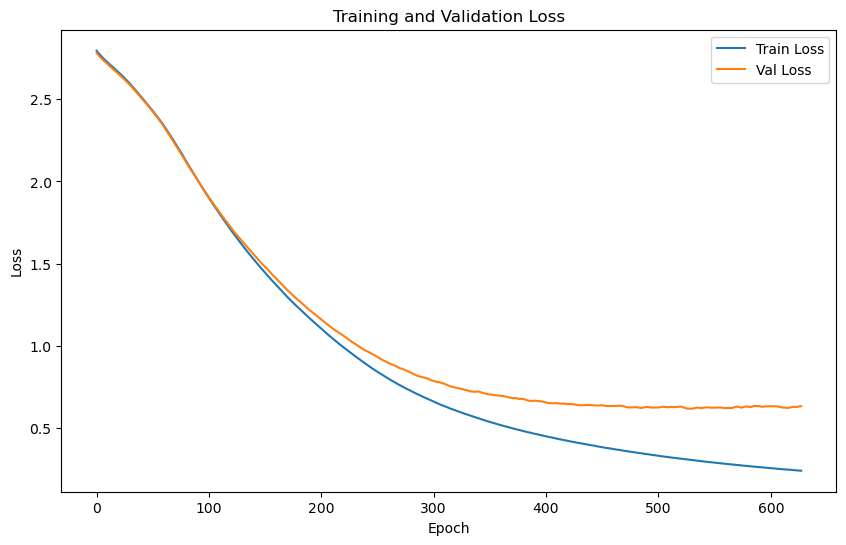

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.6806 | Test Accuracy: 79.12%


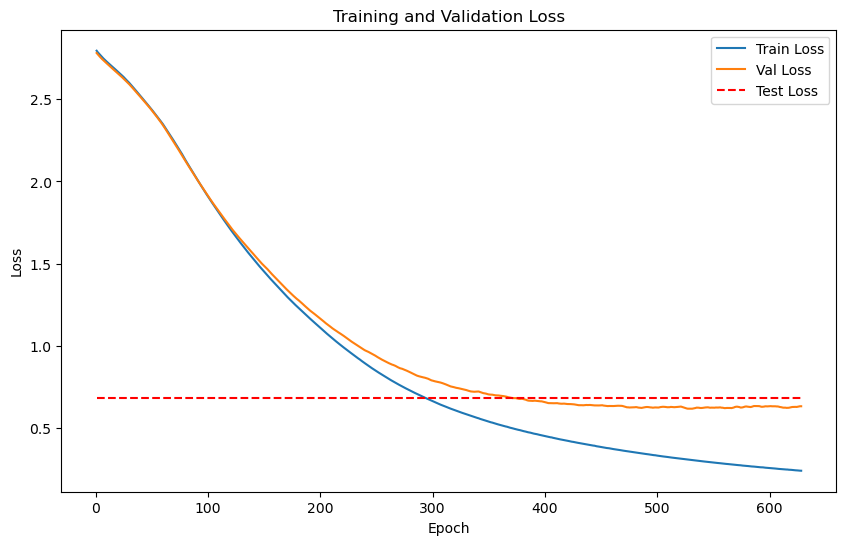

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3104
    Batch [2/2], Val Loss: 0.3276
Epoch [1/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.3190

Validation loss improved from inf to 0.3190. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.3264
Epoch [2/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.3186

Validation loss improved from 0.3190 to 0.3186. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.3257
Epoch [3/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.3183

Validation loss improved from 0.3186 to 0.3183. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.3253
Epoch [4/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.3186

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3133
    Batch [2/2], Val Loss: 0.3253
Epoch [5/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.3193

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.3261
Epoch [6/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.3206

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3165
    Batch [2/2], Val Loss: 0.3270
Epoch [7/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3218

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3276
Epoch [8/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.3225

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3185
    Batch [2/2], Val Loss: 0.3277
Epoch [9/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.3231

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3197
    Batch [2/2], Val Loss: 0.3281
Epoch [10/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.3239

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3198
    Batch [2/2], Val Loss: 0.3283
Epoch [11/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.3240

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3194
    Batch [2/2], Val Loss: 0.3287
Epoch [12/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.3240

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3191
    Batch [2/2], Val Loss: 0.3293
Epoch [13/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.3242

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3194
    Batch [2/2], Val Loss: 0.3299
Epoch [14/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3246

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3198
    Batch [2/2], Val Loss: 0.3301
Epoch [15/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.3249

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3203
    Batch [2/2], Val Loss: 0.3297
Epoch [16/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.3250

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3206
    Batch [2/2], Val Loss: 0.3289
Epoch [17/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.3248

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3211
    Batch [2/2], Val Loss: 0.3281
Epoch [18/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.3246

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3216
    Batch [2/2], Val Loss: 0.3275
Epoch [19/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3220
    Batch [2/2], Val Loss: 0.3269
Epoch [20/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3222
    Batch [2/2], Val Loss: 0.3267
Epoch [21/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3222
    Batch [2/2], Val Loss: 0.3266
Epoch [22/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3244

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3221
    Batch [2/2], Val Loss: 0.3267
Epoch [23/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3244

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3218
    Batch [2/2], Val Loss: 0.3271
Epoch [24/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3214
    Batch [2/2], Val Loss: 0.3277
Epoch [25/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3246

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3210
    Batch [2/2], Val Loss: 0.3283
Epoch [26/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3247

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3206
    Batch [2/2], Val Loss: 0.3288
Epoch [27/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3247

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3202
    Batch [2/2], Val Loss: 0.3295
Epoch [28/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3248

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3198
    Batch [2/2], Val Loss: 0.3300
Epoch [29/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3249

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3196
    Batch [2/2], Val Loss: 0.3306
Epoch [30/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3251

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3194
    Batch [2/2], Val Loss: 0.3313
Epoch [31/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3193
    Batch [2/2], Val Loss: 0.3320
Epoch [32/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3192
    Batch [2/2], Val Loss: 0.3328
Epoch [33/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3191
    Batch [2/2], Val Loss: 0.3335
Epoch [34/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3263

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3190
    Batch [2/2], Val Loss: 0.3342
Epoch [35/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3189
    Batch [2/2], Val Loss: 0.3348
Epoch [36/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3269

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3188
    Batch [2/2], Val Loss: 0.3353
Epoch [37/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3187
    Batch [2/2], Val Loss: 0.3358
Epoch [38/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3186
    Batch [2/2], Val Loss: 0.3363
Epoch [39/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3274

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3185
    Batch [2/2], Val Loss: 0.3366
Epoch [40/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3276

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3185
    Batch [2/2], Val Loss: 0.3370
Epoch [41/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.3277

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3184
    Batch [2/2], Val Loss: 0.3373
Epoch [42/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3279

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3183
    Batch [2/2], Val Loss: 0.3376
Epoch [43/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3280

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3183
    Batch [2/2], Val Loss: 0.3379
Epoch [44/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3281

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3182
    Batch [2/2], Val Loss: 0.3382
Epoch [45/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.3181
    Batch [2/2], Val Loss: 0.3384
Epoch [46/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3181
    Batch [2/2], Val Loss: 0.3386
Epoch [47/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.3180
    Batch [2/2], Val Loss: 0.3388
Epoch [48/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.3180
    Batch [2/2], Val Loss: 0.3390
Epoch [49/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3285

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3179
    Batch [2/2], Val Loss: 0.3391
Epoch [50/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3285

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3178
    Batch [2/2], Val Loss: 0.3393
Epoch [51/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.3286

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3178
    Batch [2/2], Val Loss: 0.3394
Epoch [52/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3286

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3177
    Batch [2/2], Val Loss: 0.3395
Epoch [53/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3286

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3177
    Batch [2/2], Val Loss: 0.3396
Epoch [54/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3286

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3176
    Batch [2/2], Val Loss: 0.3397
Epoch [55/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3287

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3176
    Batch [2/2], Val Loss: 0.3398
Epoch [56/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3287

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3176
    Batch [2/2], Val Loss: 0.3398
Epoch [57/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3287

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.3399
Epoch [58/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3287

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.3399
Epoch [59/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3287

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.3400
Epoch [60/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3287

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.3400
Epoch [61/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.3401
Epoch [62/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.3401
Epoch [63/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.3401
Epoch [64/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.3402
Epoch [65/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.3402
Epoch [66/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.3402
Epoch [67/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.3402
Epoch [68/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.3403
Epoch [69/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3403
Epoch [70/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3403
Epoch [71/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3403
Epoch [72/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3403
Epoch [73/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3403
Epoch [74/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3403
Epoch [75/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3403
Epoch [76/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3403
Epoch [77/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3403
Epoch [78/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3404
Epoch [79/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3404
Epoch [80/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [81/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [82/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [83/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [84/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [85/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [86/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [87/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [88/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [89/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [90/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [91/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [92/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [93/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [94/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [95/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [96/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [97/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [98/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [99/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [100/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [101/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [102/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3404
Epoch [103/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 103!!
No improvement for 100 epochs


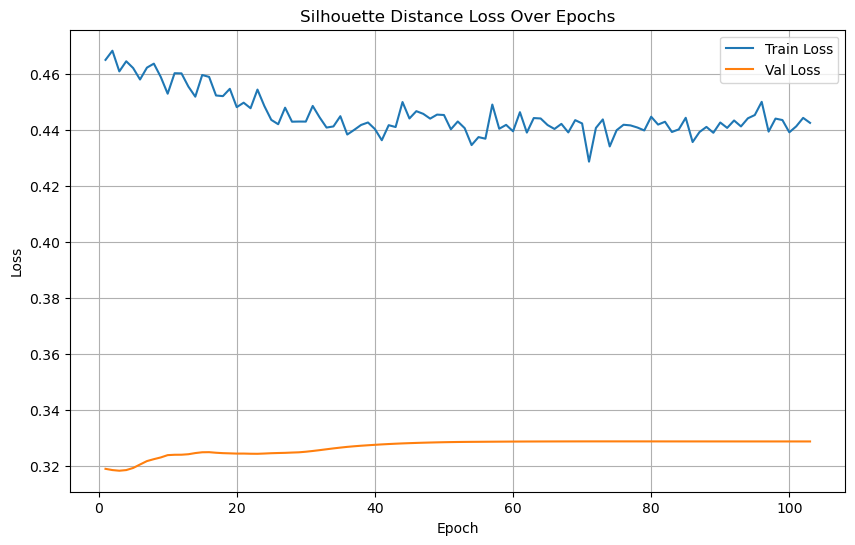

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/843], Loss: 0.1672


Test Batch [20/843], Loss: 0.1746
Test Batch [30/843], Loss: 0.1784
Test Batch [40/843], Loss: 0.1911
Test Batch [50/843], Loss: 0.1545
Test Batch [60/843], Loss: 0.2146
Test Batch [70/843], Loss: 0.1879
Test Batch [80/843], Loss: 0.2093


Test Batch [90/843], Loss: 0.1617
Test Batch [100/843], Loss: 0.2692
Test Batch [110/843], Loss: 0.5000
Test Batch [120/843], Loss: 0.1955
Test Batch [130/843], Loss: 0.2246
Test Batch [140/843], Loss: 0.2238
Test Batch [150/843], Loss: 0.2264
Test Batch [160/843], Loss: 0.3716


Test Batch [170/843], Loss: 0.4670
Test Batch [180/843], Loss: 0.3808
Test Batch [190/843], Loss: 0.3510
Test Batch [200/843], Loss: 0.1733
Test Batch [210/843], Loss: 0.0868


Test Batch [220/843], Loss: 0.1612
Test Batch [230/843], Loss: 0.1939
Test Batch [240/843], Loss: 0.1540
Test Batch [250/843], Loss: 0.1886


Test Batch [260/843], Loss: 0.2741
Test Batch [270/843], Loss: 0.2656
Test Batch [280/843], Loss: 0.3869
Test Batch [290/843], Loss: 0.3093


Test Batch [300/843], Loss: 0.3490
Test Batch [310/843], Loss: 0.3736
Test Batch [320/843], Loss: 0.2057
Test Batch [330/843], Loss: 0.3351
Test Batch [340/843], Loss: 0.3156
Test Batch [350/843], Loss: 0.5000
Test Batch [360/843], Loss: 0.0813
Test Batch [370/843], Loss: 0.5000


Test Batch [380/843], Loss: 0.5000
Test Batch [390/843], Loss: 0.5000
Test Batch [400/843], Loss: 0.5000
Test Batch [410/843], Loss: 0.5000
Test Batch [420/843], Loss: 0.5000
Test Batch [430/843], Loss: 0.0789
Test Batch [440/843], Loss: 0.0969
Test Batch [450/843], Loss: 0.2175
Test Batch [460/843], Loss: 0.1006
Test Batch [470/843], Loss: 0.1235


Test Batch [480/843], Loss: 0.1740
Test Batch [490/843], Loss: 0.5000
Test Batch [500/843], Loss: 0.1873
Test Batch [510/843], Loss: 0.1839
Test Batch [520/843], Loss: 0.2035
Test Batch [530/843], Loss: 0.2308
Test Batch [540/843], Loss: 0.2180


Test Batch [550/843], Loss: 0.2631
Test Batch [560/843], Loss: 0.2475
Test Batch [570/843], Loss: 0.2330
Test Batch [580/843], Loss: 0.1891
Test Batch [590/843], Loss: 0.2374
Test Batch [600/843], Loss: 0.5000


Test Batch [610/843], Loss: 0.1889
Test Batch [620/843], Loss: 0.1615
Test Batch [630/843], Loss: 0.1678
Test Batch [640/843], Loss: 0.2174
Test Batch [650/843], Loss: 0.4123
Test Batch [660/843], Loss: 0.2492


Test Batch [670/843], Loss: 0.1682
Test Batch [680/843], Loss: 0.3084
Test Batch [690/843], Loss: 0.3815
Test Batch [700/843], Loss: 0.1513
Test Batch [710/843], Loss: 0.2390


Test Batch [720/843], Loss: 0.1636
Test Batch [730/843], Loss: 0.2714
Test Batch [740/843], Loss: 0.5000
Test Batch [750/843], Loss: 0.5000
Test Batch [760/843], Loss: 0.2051


Test Batch [770/843], Loss: 0.2194
Test Batch [780/843], Loss: 0.2863
Test Batch [790/843], Loss: 0.5000
Test Batch [800/843], Loss: 0.1186
Test Batch [810/843], Loss: 0.2197
Test Batch [820/843], Loss: 0.5000


Test Batch [830/843], Loss: 0.1479
Test Batch [840/843], Loss: 0.5000

Test Loss: 0.2598


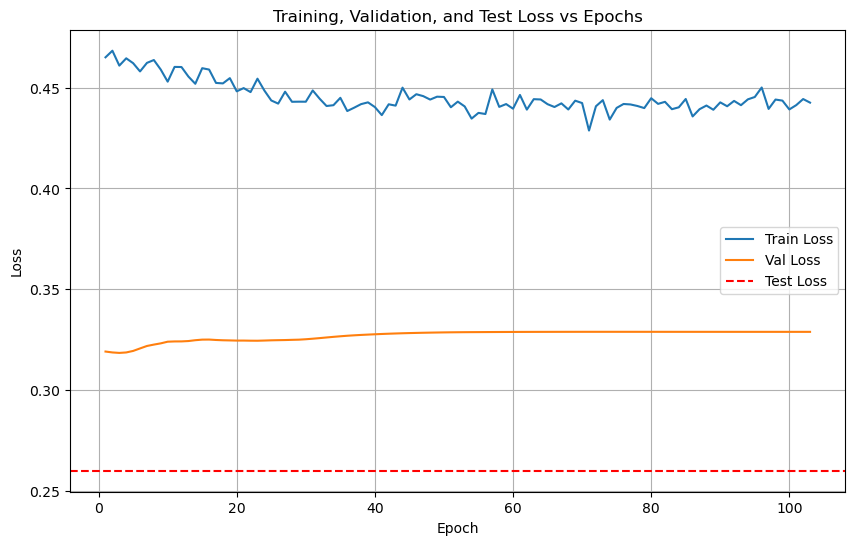

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/843 for test dataset.
  Processed batch 20/843 for test dataset.


  Processed batch 30/843 for test dataset.


  Processed batch 40/843 for test dataset.


  Processed batch 50/843 for test dataset.
  Processed batch 60/843 for test dataset.


  Processed batch 70/843 for test dataset.


  Processed batch 80/843 for test dataset.
  Processed batch 90/843 for test dataset.


  Processed batch 100/843 for test dataset.


  Processed batch 110/843 for test dataset.
  Processed batch 120/843 for test dataset.


  Processed batch 130/843 for test dataset.


  Processed batch 140/843 for test dataset.
  Processed batch 150/843 for test dataset.


  Processed batch 160/843 for test dataset.
  Processed batch 170/843 for test dataset.


  Processed batch 180/843 for test dataset.


  Processed batch 190/843 for test dataset.
  Processed batch 200/843 for test dataset.


  Processed batch 210/843 for test dataset.


  Processed batch 220/843 for test dataset.
  Processed batch 230/843 for test dataset.


  Processed batch 240/843 for test dataset.


  Processed batch 250/843 for test dataset.
  Processed batch 260/843 for test dataset.
  Processed batch 270/843 for test dataset.


  Processed batch 280/843 for test dataset.
  Processed batch 290/843 for test dataset.
  Processed batch 300/843 for test dataset.
  Processed batch 310/843 for test dataset.


  Processed batch 320/843 for test dataset.
  Processed batch 330/843 for test dataset.
  Processed batch 340/843 for test dataset.
  Processed batch 350/843 for test dataset.


  Processed batch 360/843 for test dataset.
  Processed batch 370/843 for test dataset.
  Processed batch 380/843 for test dataset.
  Processed batch 390/843 for test dataset.


  Processed batch 400/843 for test dataset.
  Processed batch 410/843 for test dataset.
  Processed batch 420/843 for test dataset.


  Processed batch 430/843 for test dataset.
  Processed batch 440/843 for test dataset.
  Processed batch 450/843 for test dataset.


  Processed batch 460/843 for test dataset.
  Processed batch 470/843 for test dataset.
  Processed batch 480/843 for test dataset.


  Processed batch 490/843 for test dataset.
  Processed batch 500/843 for test dataset.
  Processed batch 510/843 for test dataset.
  Processed batch 520/843 for test dataset.


  Processed batch 530/843 for test dataset.
  Processed batch 540/843 for test dataset.
  Processed batch 550/843 for test dataset.
  Processed batch 560/843 for test dataset.


  Processed batch 570/843 for test dataset.
  Processed batch 580/843 for test dataset.
  Processed batch 590/843 for test dataset.
  Processed batch 600/843 for test dataset.


  Processed batch 610/843 for test dataset.
  Processed batch 620/843 for test dataset.
  Processed batch 630/843 for test dataset.


  Processed batch 640/843 for test dataset.
  Processed batch 650/843 for test dataset.
  Processed batch 660/843 for test dataset.
  Processed batch 670/843 for test dataset.


  Processed batch 680/843 for test dataset.
  Processed batch 690/843 for test dataset.


  Processed batch 700/843 for test dataset.
  Processed batch 710/843 for test dataset.
  Processed batch 720/843 for test dataset.


  Processed batch 730/843 for test dataset.
  Processed batch 740/843 for test dataset.
  Processed batch 750/843 for test dataset.


  Processed batch 760/843 for test dataset.
  Processed batch 770/843 for test dataset.
  Processed batch 780/843 for test dataset.


  Processed batch 790/843 for test dataset.
  Processed batch 800/843 for test dataset.
  Processed batch 810/843 for test dataset.
  Processed batch 820/843 for test dataset.


  Processed batch 830/843 for test dataset.
  Processed batch 840/843 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       0.83      1.00      0.91         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       0.71      1.00      0.83         5
           7       0.75      0.60      0.67         5
           8       0.83      1.00      0.91         5
           9       0.60      0.60      0.60         5
          10       1.00      0.60      0.75         5
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8252  |  Val Loss: 2.8141
Validation loss improved from inf to 2.8141.
[Epoch 2/1000] Train Loss: 2.8115  |  Val Loss: 2.8020
Validation loss improved from 2.8141 to 2.8020.
[Epoch 3/1000] Train Loss: 2.7994  |  Val Loss: 2.7899
Validation loss improved from 2.8020 to 2.7899.
[Epoch 4/1000] Train Loss: 2.7875  |  Val Loss: 2.7788
Validation loss improved from 2.7899 to 2.7788.
[Epoch 5/1000] Train Loss: 2.7760  |  Val Loss: 2.7678
Validation loss improved from 2.7788 to 2.7678.
[Epoch 6/1000] Train Loss: 2.7644  |  Val Loss: 2.7567
Validation loss improved from 2.7678 to 2.7567.
[Epoch 7/1000] Train Loss: 2.7531  |  Val Loss: 2.7459
Validation loss improved from 2.7567 to 2.7459.
[Epoch 8/1000] Train Loss: 2.7424  |  Val Loss: 2.7350
Validation loss improved from 2.7459 to 2.7350.
[Epoch 9/1000] Train Loss: 2.7313  |  Val Loss: 2.7245
Validation loss improved from 2.7350 to 2.7245.
[Epoch 10/1000] Train Loss: 2.7216  |  Val Loss: 2.7143
Validation loss impr

[Epoch 25/1000] Train Loss: 2.5839  |  Val Loss: 2.5840
Validation loss improved from 2.5919 to 2.5840.


[Epoch 26/1000] Train Loss: 2.5759  |  Val Loss: 2.5761
Validation loss improved from 2.5840 to 2.5761.
[Epoch 27/1000] Train Loss: 2.5675  |  Val Loss: 2.5682
Validation loss improved from 2.5761 to 2.5682.
[Epoch 28/1000] Train Loss: 2.5590  |  Val Loss: 2.5602
Validation loss improved from 2.5682 to 2.5602.
[Epoch 29/1000] Train Loss: 2.5504  |  Val Loss: 2.5522
Validation loss improved from 2.5602 to 2.5522.
[Epoch 30/1000] Train Loss: 2.5413  |  Val Loss: 2.5441
Validation loss improved from 2.5522 to 2.5441.
[Epoch 31/1000] Train Loss: 2.5326  |  Val Loss: 2.5358
Validation loss improved from 2.5441 to 2.5358.
[Epoch 32/1000] Train Loss: 2.5235  |  Val Loss: 2.5274
Validation loss improved from 2.5358 to 2.5274.
[Epoch 33/1000] Train Loss: 2.5142  |  Val Loss: 2.5189
Validation loss improved from 2.5274 to 2.5189.
[Epoch 34/1000] Train Loss: 2.5044  |  Val Loss: 2.5104
Validation loss improved from 2.5189 to 2.5104.
[Epoch 35/1000] Train Loss: 2.4951  |  Val Loss: 2.5015
Validati

[Epoch 56/1000] Train Loss: 2.2761  |  Val Loss: 2.3112
Validation loss improved from 2.3204 to 2.3112.
[Epoch 57/1000] Train Loss: 2.2657  |  Val Loss: 2.3018
Validation loss improved from 2.3112 to 2.3018.
[Epoch 58/1000] Train Loss: 2.2544  |  Val Loss: 2.2926
Validation loss improved from 2.3018 to 2.2926.
[Epoch 59/1000] Train Loss: 2.2437  |  Val Loss: 2.2834
Validation loss improved from 2.2926 to 2.2834.
[Epoch 60/1000] Train Loss: 2.2327  |  Val Loss: 2.2741
Validation loss improved from 2.2834 to 2.2741.
[Epoch 61/1000] Train Loss: 2.2213  |  Val Loss: 2.2647
Validation loss improved from 2.2741 to 2.2647.
[Epoch 62/1000] Train Loss: 2.2104  |  Val Loss: 2.2549
Validation loss improved from 2.2647 to 2.2549.
[Epoch 63/1000] Train Loss: 2.1990  |  Val Loss: 2.2451
Validation loss improved from 2.2549 to 2.2451.
[Epoch 64/1000] Train Loss: 2.1878  |  Val Loss: 2.2351
Validation loss improved from 2.2451 to 2.2351.
[Epoch 65/1000] Train Loss: 2.1759  |  Val Loss: 2.2252
Validati

[Epoch 82/1000] Train Loss: 1.9763  |  Val Loss: 2.0501
Validation loss improved from 2.0609 to 2.0501.
[Epoch 83/1000] Train Loss: 1.9643  |  Val Loss: 2.0393
Validation loss improved from 2.0501 to 2.0393.
[Epoch 84/1000] Train Loss: 1.9523  |  Val Loss: 2.0285
Validation loss improved from 2.0393 to 2.0285.
[Epoch 85/1000] Train Loss: 1.9402  |  Val Loss: 2.0176
Validation loss improved from 2.0285 to 2.0176.
[Epoch 86/1000] Train Loss: 1.9282  |  Val Loss: 2.0067
Validation loss improved from 2.0176 to 2.0067.
[Epoch 87/1000] Train Loss: 1.9161  |  Val Loss: 1.9959
Validation loss improved from 2.0067 to 1.9959.
[Epoch 88/1000] Train Loss: 1.9043  |  Val Loss: 1.9851
Validation loss improved from 1.9959 to 1.9851.
[Epoch 89/1000] Train Loss: 1.8925  |  Val Loss: 1.9742
Validation loss improved from 1.9851 to 1.9742.
[Epoch 90/1000] Train Loss: 1.8802  |  Val Loss: 1.9637
Validation loss improved from 1.9742 to 1.9637.
[Epoch 91/1000] Train Loss: 1.8682  |  Val Loss: 1.9529
Validati

[Epoch 110/1000] Train Loss: 1.6388  |  Val Loss: 1.7529
Validation loss improved from 1.7632 to 1.7529.
[Epoch 111/1000] Train Loss: 1.6266  |  Val Loss: 1.7425
Validation loss improved from 1.7529 to 1.7425.
[Epoch 112/1000] Train Loss: 1.6144  |  Val Loss: 1.7321
Validation loss improved from 1.7425 to 1.7321.
[Epoch 113/1000] Train Loss: 1.6023  |  Val Loss: 1.7215
Validation loss improved from 1.7321 to 1.7215.
[Epoch 114/1000] Train Loss: 1.5902  |  Val Loss: 1.7110
Validation loss improved from 1.7215 to 1.7110.
[Epoch 115/1000] Train Loss: 1.5782  |  Val Loss: 1.7009
Validation loss improved from 1.7110 to 1.7009.
[Epoch 116/1000] Train Loss: 1.5656  |  Val Loss: 1.6904
Validation loss improved from 1.7009 to 1.6904.
[Epoch 117/1000] Train Loss: 1.5534  |  Val Loss: 1.6796
Validation loss improved from 1.6904 to 1.6796.
[Epoch 118/1000] Train Loss: 1.5411  |  Val Loss: 1.6690
Validation loss improved from 1.6796 to 1.6690.
[Epoch 119/1000] Train Loss: 1.5280  |  Val Loss: 1.658

[Epoch 141/1000] Train Loss: 1.2620  |  Val Loss: 1.4423
Validation loss improved from 1.4517 to 1.4423.
[Epoch 142/1000] Train Loss: 1.2507  |  Val Loss: 1.4331
Validation loss improved from 1.4423 to 1.4331.
[Epoch 143/1000] Train Loss: 1.2398  |  Val Loss: 1.4241
Validation loss improved from 1.4331 to 1.4241.
[Epoch 144/1000] Train Loss: 1.2288  |  Val Loss: 1.4155
Validation loss improved from 1.4241 to 1.4155.
[Epoch 145/1000] Train Loss: 1.2177  |  Val Loss: 1.4069
Validation loss improved from 1.4155 to 1.4069.
[Epoch 146/1000] Train Loss: 1.2073  |  Val Loss: 1.3981
Validation loss improved from 1.4069 to 1.3981.
[Epoch 147/1000] Train Loss: 1.1964  |  Val Loss: 1.3892
Validation loss improved from 1.3981 to 1.3892.
[Epoch 148/1000] Train Loss: 1.1858  |  Val Loss: 1.3803
Validation loss improved from 1.3892 to 1.3803.
[Epoch 149/1000] Train Loss: 1.1753  |  Val Loss: 1.3717
Validation loss improved from 1.3803 to 1.3717.
[Epoch 150/1000] Train Loss: 1.1645  |  Val Loss: 1.363

[Epoch 172/1000] Train Loss: 0.9519  |  Val Loss: 1.1957
Validation loss improved from 1.2028 to 1.1957.
[Epoch 173/1000] Train Loss: 0.9431  |  Val Loss: 1.1885
Validation loss improved from 1.1957 to 1.1885.
[Epoch 174/1000] Train Loss: 0.9341  |  Val Loss: 1.1814
Validation loss improved from 1.1885 to 1.1814.
[Epoch 175/1000] Train Loss: 0.9256  |  Val Loss: 1.1742
Validation loss improved from 1.1814 to 1.1742.
[Epoch 176/1000] Train Loss: 0.9170  |  Val Loss: 1.1674
Validation loss improved from 1.1742 to 1.1674.
[Epoch 177/1000] Train Loss: 0.9084  |  Val Loss: 1.1606
Validation loss improved from 1.1674 to 1.1606.
[Epoch 178/1000] Train Loss: 0.9003  |  Val Loss: 1.1540
Validation loss improved from 1.1606 to 1.1540.
[Epoch 179/1000] Train Loss: 0.8915  |  Val Loss: 1.1472
Validation loss improved from 1.1540 to 1.1472.
[Epoch 180/1000] Train Loss: 0.8833  |  Val Loss: 1.1406
Validation loss improved from 1.1472 to 1.1406.
[Epoch 181/1000] Train Loss: 0.8751  |  Val Loss: 1.134

[Epoch 201/1000] Train Loss: 0.7254  |  Val Loss: 1.0171
Validation loss improved from 1.0219 to 1.0171.
[Epoch 202/1000] Train Loss: 0.7185  |  Val Loss: 1.0122
Validation loss improved from 1.0171 to 1.0122.
[Epoch 203/1000] Train Loss: 0.7119  |  Val Loss: 1.0074
Validation loss improved from 1.0122 to 1.0074.
[Epoch 204/1000] Train Loss: 0.7055  |  Val Loss: 1.0029
Validation loss improved from 1.0074 to 1.0029.
[Epoch 205/1000] Train Loss: 0.6992  |  Val Loss: 0.9986
Validation loss improved from 1.0029 to 0.9986.
[Epoch 206/1000] Train Loss: 0.6930  |  Val Loss: 0.9942
Validation loss improved from 0.9986 to 0.9942.
[Epoch 207/1000] Train Loss: 0.6870  |  Val Loss: 0.9896
Validation loss improved from 0.9942 to 0.9896.
[Epoch 208/1000] Train Loss: 0.6807  |  Val Loss: 0.9853
Validation loss improved from 0.9896 to 0.9853.
[Epoch 209/1000] Train Loss: 0.6746  |  Val Loss: 0.9811
Validation loss improved from 0.9853 to 0.9811.
[Epoch 210/1000] Train Loss: 0.6688  |  Val Loss: 0.977

[Epoch 226/1000] Train Loss: 0.5825  |  Val Loss: 0.9241
Validation loss improved from 0.9273 to 0.9241.
[Epoch 227/1000] Train Loss: 0.5776  |  Val Loss: 0.9208
Validation loss improved from 0.9241 to 0.9208.
[Epoch 228/1000] Train Loss: 0.5727  |  Val Loss: 0.9175
Validation loss improved from 0.9208 to 0.9175.
[Epoch 229/1000] Train Loss: 0.5685  |  Val Loss: 0.9143
Validation loss improved from 0.9175 to 0.9143.
[Epoch 230/1000] Train Loss: 0.5637  |  Val Loss: 0.9115
Validation loss improved from 0.9143 to 0.9115.
[Epoch 231/1000] Train Loss: 0.5592  |  Val Loss: 0.9088
Validation loss improved from 0.9115 to 0.9088.
[Epoch 232/1000] Train Loss: 0.5544  |  Val Loss: 0.9062
Validation loss improved from 0.9088 to 0.9062.
[Epoch 233/1000] Train Loss: 0.5501  |  Val Loss: 0.9036
Validation loss improved from 0.9062 to 0.9036.
[Epoch 234/1000] Train Loss: 0.5456  |  Val Loss: 0.9013
Validation loss improved from 0.9036 to 0.9013.
[Epoch 235/1000] Train Loss: 0.5414  |  Val Loss: 0.899

[Epoch 255/1000] Train Loss: 0.4647  |  Val Loss: 0.8593
Validation loss improved from 0.8605 to 0.8593.
[Epoch 256/1000] Train Loss: 0.4613  |  Val Loss: 0.8575
Validation loss improved from 0.8593 to 0.8575.
[Epoch 257/1000] Train Loss: 0.4580  |  Val Loss: 0.8560
Validation loss improved from 0.8575 to 0.8560.
[Epoch 258/1000] Train Loss: 0.4547  |  Val Loss: 0.8544
Validation loss improved from 0.8560 to 0.8544.
[Epoch 259/1000] Train Loss: 0.4512  |  Val Loss: 0.8530
Validation loss improved from 0.8544 to 0.8530.
[Epoch 260/1000] Train Loss: 0.4483  |  Val Loss: 0.8520
Validation loss improved from 0.8530 to 0.8520.
[Epoch 261/1000] Train Loss: 0.4451  |  Val Loss: 0.8508
Validation loss improved from 0.8520 to 0.8508.
[Epoch 262/1000] Train Loss: 0.4420  |  Val Loss: 0.8498
Validation loss improved from 0.8508 to 0.8498.
[Epoch 263/1000] Train Loss: 0.4387  |  Val Loss: 0.8486
Validation loss improved from 0.8498 to 0.8486.
[Epoch 264/1000] Train Loss: 0.4357  |  Val Loss: 0.847

[Epoch 287/1000] Train Loss: 0.3728  |  Val Loss: 0.8235
Validation loss improved from 0.8240 to 0.8235.
[Epoch 288/1000] Train Loss: 0.3703  |  Val Loss: 0.8226
Validation loss improved from 0.8235 to 0.8226.
[Epoch 289/1000] Train Loss: 0.3680  |  Val Loss: 0.8220
Validation loss improved from 0.8226 to 0.8220.
[Epoch 290/1000] Train Loss: 0.3658  |  Val Loss: 0.8210
Validation loss improved from 0.8220 to 0.8210.
[Epoch 291/1000] Train Loss: 0.3633  |  Val Loss: 0.8198
Validation loss improved from 0.8210 to 0.8198.
[Epoch 292/1000] Train Loss: 0.3612  |  Val Loss: 0.8189
Validation loss improved from 0.8198 to 0.8189.
[Epoch 293/1000] Train Loss: 0.3588  |  Val Loss: 0.8184
Validation loss improved from 0.8189 to 0.8184.
[Epoch 294/1000] Train Loss: 0.3565  |  Val Loss: 0.8178
Validation loss improved from 0.8184 to 0.8178.
[Epoch 295/1000] Train Loss: 0.3543  |  Val Loss: 0.8177
Validation loss improved from 0.8178 to 0.8177.
[Epoch 296/1000] Train Loss: 0.3519  |  Val Loss: 0.817

[Epoch 317/1000] Train Loss: 0.3088  |  Val Loss: 0.8086
Validation loss improved from 0.8090 to 0.8086.
[Epoch 318/1000] Train Loss: 0.3070  |  Val Loss: 0.8081
Validation loss improved from 0.8086 to 0.8081.
[Epoch 319/1000] Train Loss: 0.3053  |  Val Loss: 0.8079
Validation loss improved from 0.8081 to 0.8079.
[Epoch 320/1000] Train Loss: 0.3032  |  Val Loss: 0.8075
Validation loss improved from 0.8079 to 0.8075.
[Epoch 321/1000] Train Loss: 0.3015  |  Val Loss: 0.8071
Validation loss improved from 0.8075 to 0.8071.
[Epoch 322/1000] Train Loss: 0.2997  |  Val Loss: 0.8069
Validation loss improved from 0.8071 to 0.8069.
[Epoch 323/1000] Train Loss: 0.2980  |  Val Loss: 0.8072
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 324/1000] Train Loss: 0.2961  |  Val Loss: 0.8074
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 325/1000] Train Loss: 0.2942  |  Val Loss: 0.8075
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 326/1000] Train Loss: 0.2926  

[Epoch 344/1000] Train Loss: 0.2637  |  Val Loss: 0.8102
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 345/1000] Train Loss: 0.2624  |  Val Loss: 0.8105
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 346/1000] Train Loss: 0.2608  |  Val Loss: 0.8102
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 347/1000] Train Loss: 0.2595  |  Val Loss: 0.8100
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 348/1000] Train Loss: 0.2580  |  Val Loss: 0.8094
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 349/1000] Train Loss: 0.2565  |  Val Loss: 0.8094
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 350/1000] Train Loss: 0.2551  |  Val Loss: 0.8100
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 351/1000] Train Loss: 0.2536  |  Val Loss: 0.8101
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 352/1000] Train Loss: 0.2522  |  Val Loss: 0.8102
!! Validation loss did NOT improve !! Patience:

[Epoch 372/1000] Train Loss: 0.2268  |  Val Loss: 0.8163
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 373/1000] Train Loss: 0.2253  |  Val Loss: 0.8169
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 374/1000] Train Loss: 0.2241  |  Val Loss: 0.8176
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 375/1000] Train Loss: 0.2230  |  Val Loss: 0.8185
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 376/1000] Train Loss: 0.2219  |  Val Loss: 0.8190
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 377/1000] Train Loss: 0.2207  |  Val Loss: 0.8190
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 378/1000] Train Loss: 0.2196  |  Val Loss: 0.8192
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 379/1000] Train Loss: 0.2185  |  Val Loss: 0.8192
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 380/1000] Train Loss: 0.2174  |  Val Loss: 0.8192
!! Validation loss did NOT improve !! Patience:

[Epoch 402/1000] Train Loss: 0.1947  |  Val Loss: 0.8262
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 403/1000] Train Loss: 0.1936  |  Val Loss: 0.8266
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 404/1000] Train Loss: 0.1928  |  Val Loss: 0.8267
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 405/1000] Train Loss: 0.1917  |  Val Loss: 0.8274
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 406/1000] Train Loss: 0.1910  |  Val Loss: 0.8283
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 407/1000] Train Loss: 0.1899  |  Val Loss: 0.8286
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 408/1000] Train Loss: 0.1891  |  Val Loss: 0.8294
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 409/1000] Train Loss: 0.1881  |  Val Loss: 0.8298
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 410/1000] Train Loss: 0.1872  |  Val Loss: 0.8307
!! Validation loss did NOT improve !! Patience:

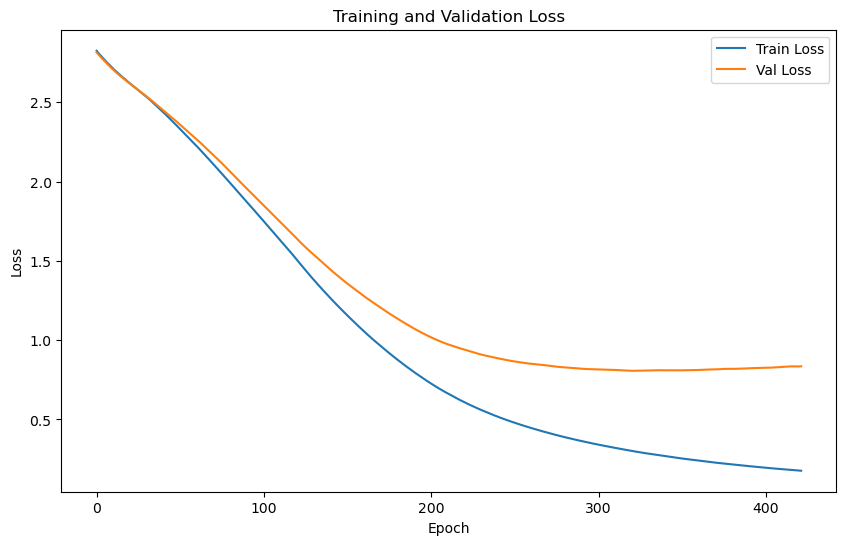

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7545 | Test Accuracy: 78.12%


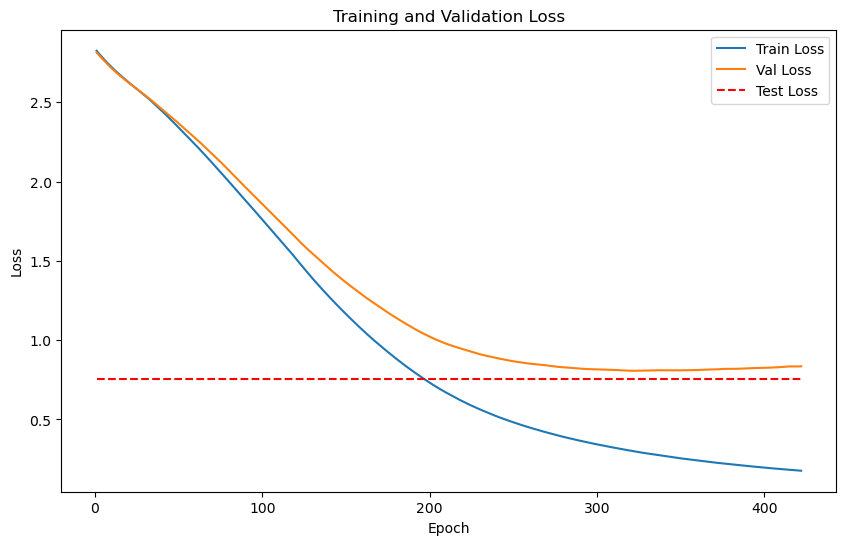

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


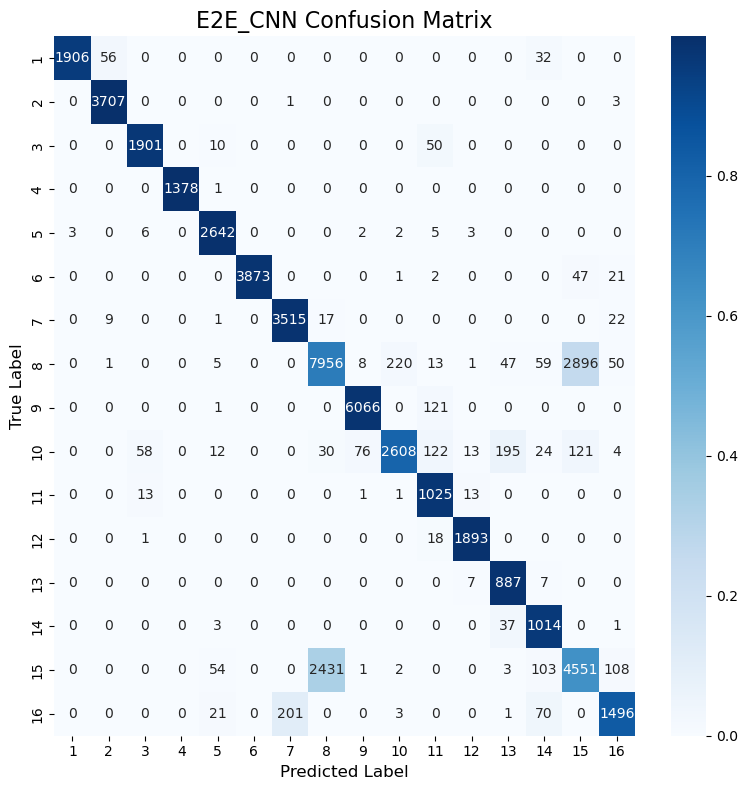

Classification Accuracy: 86.14%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


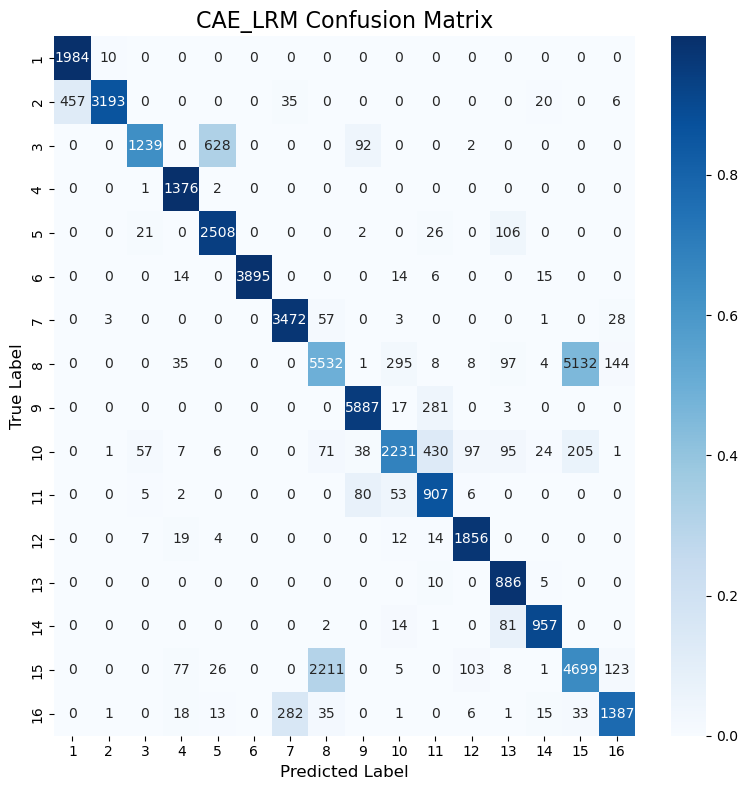

Classification Accuracy: 77.95%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


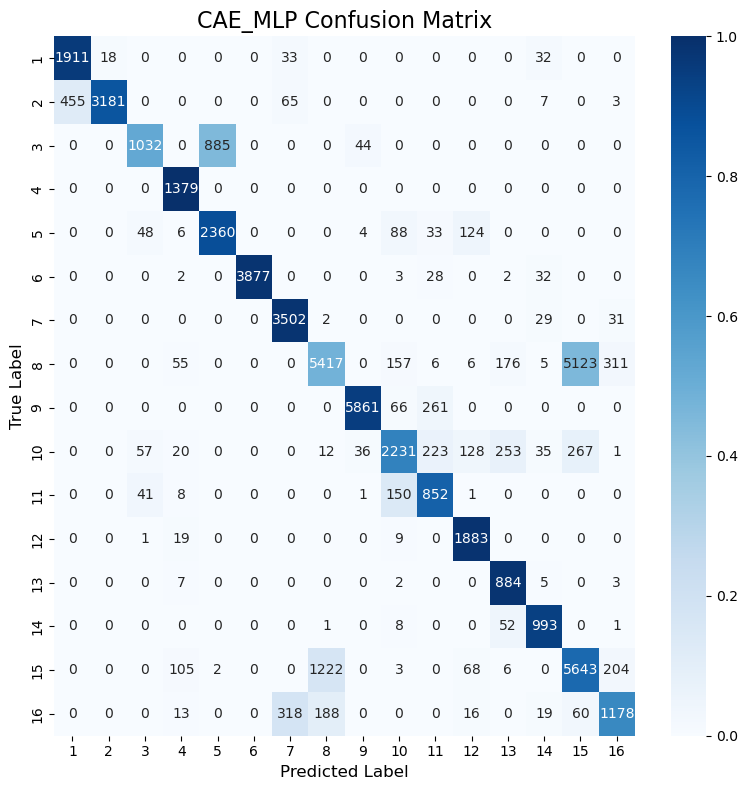

Classification Accuracy: 78.28%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


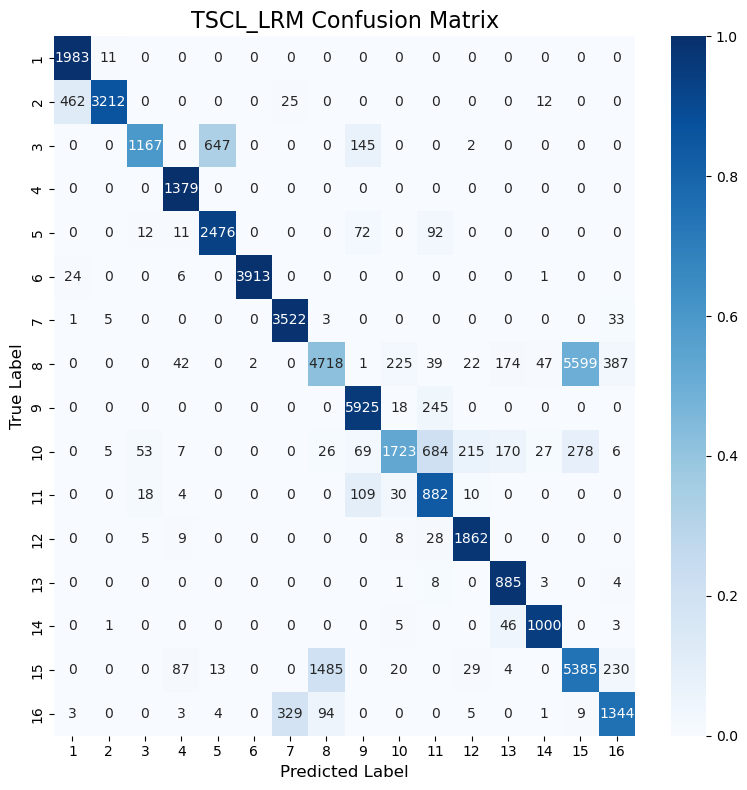

Classification Accuracy: 76.78%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


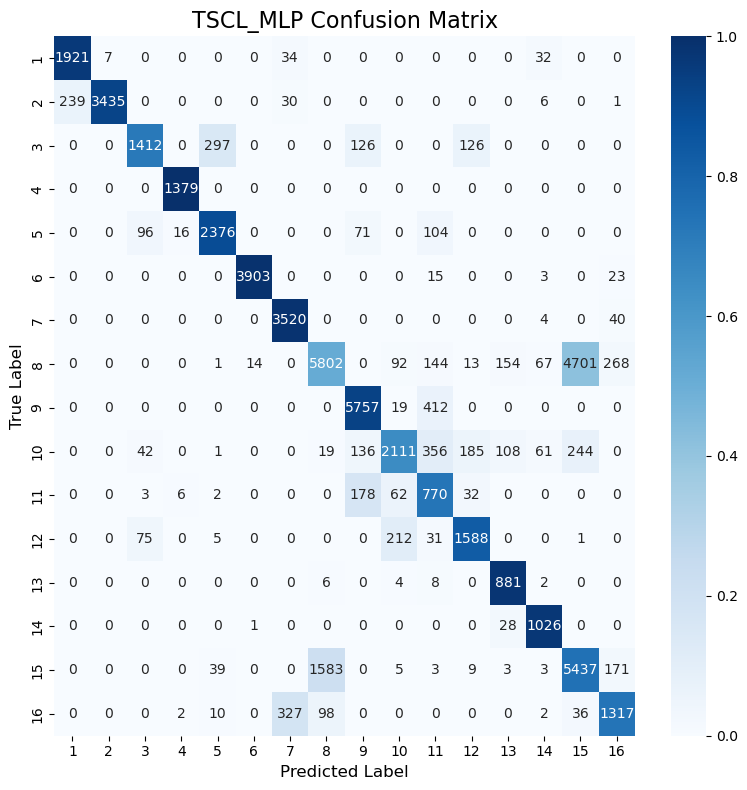

Classification Accuracy: 79.12%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


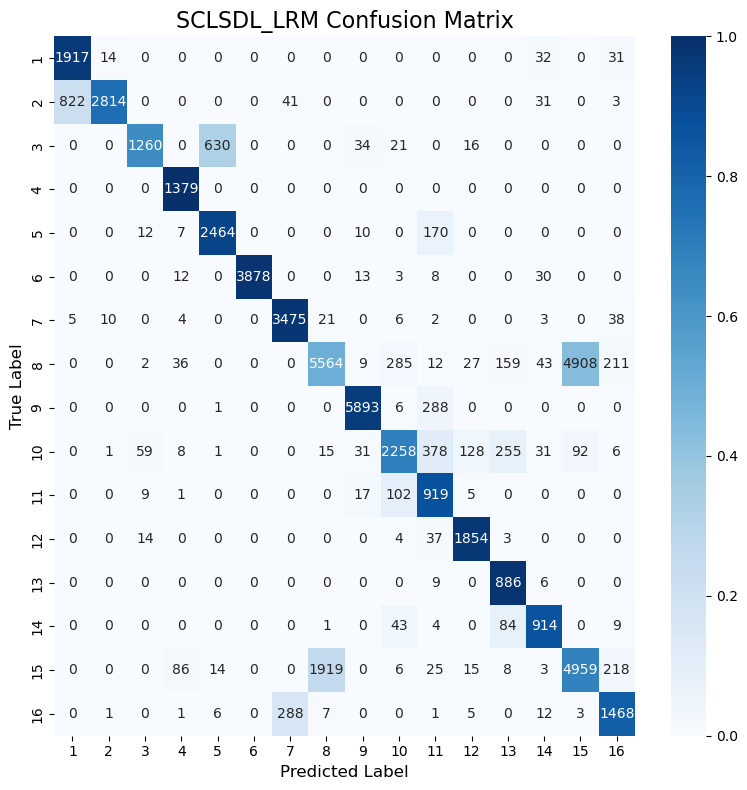

Classification Accuracy: 77.76%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


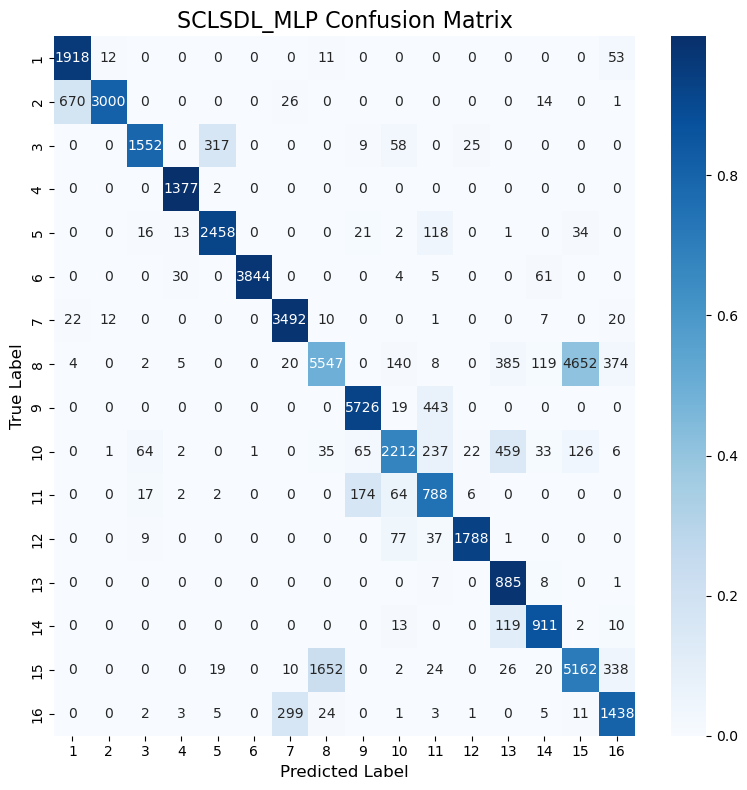

Classification Accuracy: 78.12%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          86.14
1    LRM (CAE)          77.95
2    MLP (CAE)          78.28
3     TSCL LRM          76.78
4     TSCL MLP          79.12
5  SCL_SDL LRM          77.76
6  SCL_SDL MLP          78.12

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          86.14
4     TSCL MLP          79.12
2    MLP (CAE)          78.28
6  SCL_SDL MLP          78.12
1    LRM (CAE)          77.95
5  SCL_SDL LRM          77.76
3     TSCL LRM          76.78
